In [3]:
import numpy as np
import pandas as pd
import psycopg2
from datetime import datetime, timedelta
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [4]:
conn = psycopg2.connect(
    host="172.17.30.1",
    port = "5432",
    database="dwh",
    user="kurganbaev_f",
    password="Q5no_mxins6")
print('connection successful')
print(datetime.now())

connection successful
2025-02-25 11:38:34.100140


In [6]:
#conn.close()

## Creating a dataframe for p2p statistics

In [ ]:
df = pd.read_sql("""
                select *
                from payme_sandbox.p2p_user_activation_classification
                order by payer_id, create_time
                """, con = conn)

In [ ]:
print(datetime.now())

In [ ]:
df['gap_days'] = df.groupby('payer_id')['days_after_reg'].diff()

In [ ]:
df['reg_date'] = pd.to_datetime(df['reg_date'])
df['create_time'] = pd.to_datetime(df['create_time'])

In [ ]:
df['reg_date'] = df['reg_date'] + timedelta(hours=5)
df['create_time'] = df['create_time'] + timedelta(hours=5)

In [ ]:
df['create_date'] = df['create_time'].dt.strftime('%Y-%m-%d')

In [ ]:
df.head()

In [ ]:
transfers_stats = df.groupby('payer_id').agg(
    # Stats for days_after_registration
    mean_days=('days_after_reg', 'mean'),
    median_days=('days_after_reg', 'median'),
    std_days=('days_after_reg', 'std'),
    min_days=('days_after_reg', 'min'),
    max_days=('days_after_reg', 'max'),
    count_days=('create_date', 'nunique'),
    skew_days=('days_after_reg', pd.Series.skew),
    kurtosis_days=('days_after_reg', pd.Series.kurtosis),
    q25_days=('days_after_reg', lambda x: x.quantile(0.25)),
    q75_days=('days_after_reg', lambda x: x.quantile(0.75)), 
    q90_days=('days_after_reg', lambda x: x.quantile(0.90)),
    # Stats for amount
    mean_amount=('amount', 'mean'),
    median_amount=('amount', 'median'),
    count_trn=('amount', 'count'),
    sum_amount=('amount', 'sum'),
    std_amount=('amount', 'std'), 

    median_gap=('gap_days', 'median')
)

In [ ]:
print(datetime.now())

In [ ]:
transfers_stats['iqr'] = transfers_stats['q75_days'] - transfers_stats['q25_days']

In [ ]:
transfers_stats['variation'] = 2*(transfers_stats['iqr'] * transfers_stats['count_days']) / (transfers_stats['iqr'] + transfers_stats['count_days'])

In [ ]:
transfers_stats = transfers_stats.reset_index()

In [ ]:
#transfers_stats.to_csv('transfers_stats.csv', index = False)

## Importing statistics on P2P

In [409]:
transfers_stats = pd.read_csv('transfers_stats.csv')

In [410]:
transfers_stats.drop(columns = ['Unnamed: 0'], inplace = True)

In [411]:
df_cluster = transfers_stats.copy()

In [412]:
df_cluster = df_cluster.fillna(0)

In [413]:
df_corr = df_cluster.drop(columns=['payer_id'])
corr_matrix = df_corr.corr()

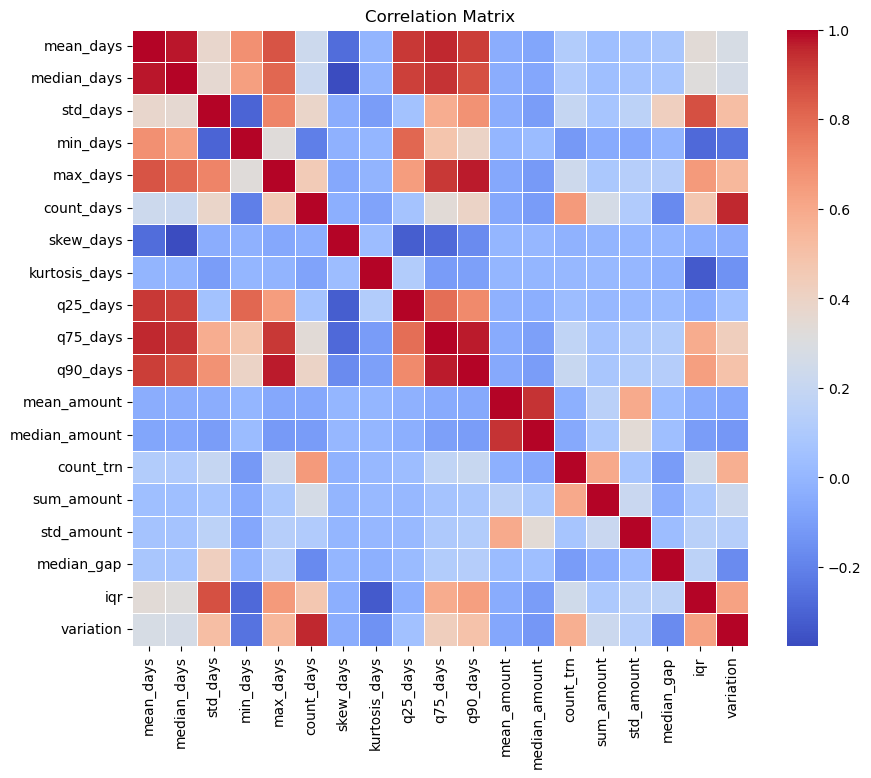

In [414]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True)
plt.title("Correlation Matrix")
plt.show()

In [415]:
#df_cluster = df_cluster.sample(170000)

In [416]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

In [417]:
features = df_cluster.drop(columns=['payer_id', 'mean_days', 'std_days', 'min_days', 'median_days', 'skew_days', 'max_days', 'count_trn', 'std_amount', 'median_amount', 'kurtosis_days', 'q25_days', 'q75_days', 'variation'])

In [418]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(features)

In [419]:
features.head()

count_days    q90_days    mean_amount  sum_amount  median_gap        iqr
0          44  230.958450   87691.176471   5963000.0    0.896098  63.927816
1           6  106.665221  102500.000000    615000.0    7.147623  92.950577
2          12  163.522427   70769.230769    920000.0   11.540681  65.164710
3          25   68.887924   53715.909091   2363500.0    0.843067  33.650287
4           1  264.938804  120000.000000    120000.0    0.000000   0.000000

In [420]:
bic = []
for k in range(1, 10):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(normalized_data)
    bic.append(gmm.bic(normalized_data))

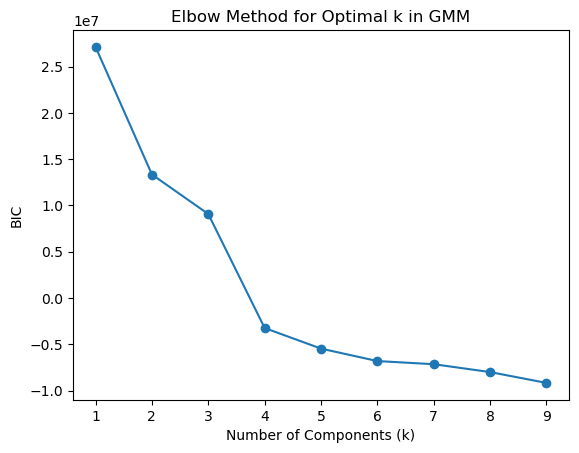

In [421]:
plt.plot(range(1, 10), bic, marker='o')
plt.xlabel('Number of Components (k)')
plt.ylabel('BIC')
plt.title('Elbow Method for Optimal k in GMM')
plt.show()

In [422]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(3, 8):  
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(normalized_data)
    labels = gmm.predict(normalized_data)
    score = silhouette_score(normalized_data, labels)
    silhouette_scores.append(score)

KeyboardInterrupt: 

In [ ]:
plt.plot(range(3, 8), silhouette_scores, marker='o')
plt.xlabel('Number of Components (k)')
plt.ylabel('silhouette_scores')
plt.title('Silhouette scores for Optimal k in GMM')
plt.show()

In [423]:
gmm = GaussianMixture(n_components=4, random_state=42) 
df_cluster['cluster'] = gmm.fit_predict(normalized_data)

In [424]:
probabilities = gmm.predict_proba(normalized_data)

In [425]:
probabilities_df = pd.DataFrame(
    probabilities, 
    columns=[f'cluster_{i}_probability' for i in range(4)]
)

In [426]:
df_cluster = pd.concat([df_cluster, probabilities_df], axis=1)

In [427]:
df_cluster.groupby('cluster')['payer_id'].count()/df_cluster['payer_id'].count()*100

cluster
0    39.930998
1    17.544689
2    33.183077
3     9.341237
Name: payer_id, dtype: float64

In [428]:
df_cluster.groupby('cluster')['sum_amount'].sum()/df_cluster['sum_amount'].sum()*100

cluster
0    36.079108
1     0.976560
2     5.665195
3    57.279137
Name: sum_amount, dtype: float64

In [429]:
df_cluster[df_cluster.count_days == 1].groupby('cluster')['payer_id'].count()

cluster
0       310
1    297283
2     14162
3      6088
Name: payer_id, dtype: int64

### from low top to best fit

In [430]:
top_df = df_cluster[df_cluster['cluster'] == 3]

conditions = [
    (df_cluster['cluster'] == 3) & (df_cluster['count_days'] < top_df['count_days'].quantile(0.25)),
    (df_cluster['cluster'] == 3) & (df_cluster['q90_days'] < top_df['q90_days'].quantile(0.15)),
    (df_cluster['cluster'] == 3) & (df_cluster['sum_amount'] < top_df['sum_amount'].quantile(0.25)),
    (df_cluster['cluster'] == 3) & (df_cluster['iqr'] < top_df['iqr'].quantile(0.25))
]

probability_columns = ['cluster_0_probability', 'cluster_1_probability', 'cluster_2_probability']
df_cluster['max_probability_cluster'] = df_cluster[probability_columns].idxmax(axis=1).str.extract('(\d)').astype(int)


for x in conditions:
    df_cluster.loc[x, 'cluster'] = df_cluster.loc[x, 'max_probability_cluster']

### from standard to low

In [431]:
standard_df = df_cluster[df_cluster['cluster'] == 0]

df_cluster.loc[(df_cluster['cluster'] == 0) & (df_cluster['count_days'] < standard_df['count_days'].quantile(0.25)), 'cluster'] = 2
df_cluster.loc[(df_cluster['cluster'] == 0) & (df_cluster['sum_amount'] < standard_df['sum_amount'].quantile(0.15)), 'cluster'] = 2
df_cluster.loc[(df_cluster['cluster'] == 0) & (df_cluster['iqr'] < standard_df['iqr'].quantile(0.20)), 'cluster'] = 2

### to one timer

In [432]:
df_cluster.loc[df_cluster['count_days'] == 1, 'cluster'] = 1

In [433]:
cluster_mapping = {0: 'standard', 1: 'one_timer', 2: 'low', 3: 'top'}
df_cluster['cluster_name'] = df_cluster['cluster'].map(cluster_mapping).fillna('unknown')

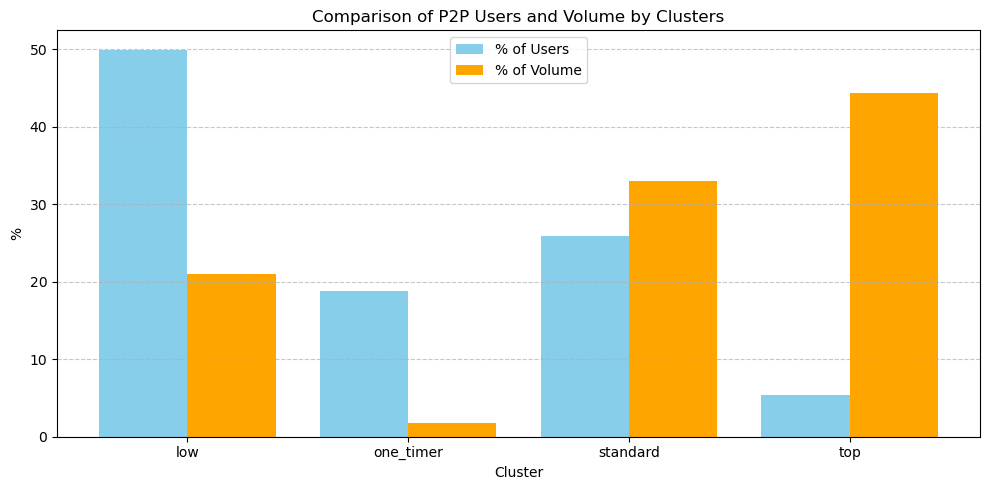

In [434]:
payer_counts_percentage = (
    df_cluster.groupby('cluster_name')['payer_id'].count() / df_cluster['payer_id'].count() * 100
)
sum_amount_percentage = (
    df_cluster.groupby('cluster_name')['sum_amount'].sum() / df_cluster['sum_amount'].sum() * 100
)

# Set up the figure and axes for side-by-side bar charts
fig, ax = plt.subplots(figsize=(10, 5))

# Define the positions for the bars
x = np.arange(len(payer_counts_percentage.index))  # Positions for bars
bar_width = 0.4  # Width of each bar

# Plot the bar charts
ax.bar(x - bar_width/2, payer_counts_percentage, width=bar_width, label='% of Users', color='skyblue')
ax.bar(x + bar_width/2, sum_amount_percentage, width=bar_width, label='% of Volume', color='orange')

# Add labels, title, and legend
ax.set_xlabel('Cluster')
ax.set_ylabel('%')
ax.set_title('Comparison of P2P Users and Volume by Clusters')
ax.set_xticks(x)
ax.set_xticklabels(payer_counts_percentage.index, rotation=0)  # Keep labels horizontal
ax.legend(loc = 'upper center')

# Show the plot
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [435]:
col_list = ['median_days', 'std_days', 'min_days',
       'max_days', 'count_days', 'q25_days', 'q90_days', 
       'mean_amount', 'median_amount', 'count_trn', 'sum_amount',
       'median_gap', 'iqr']

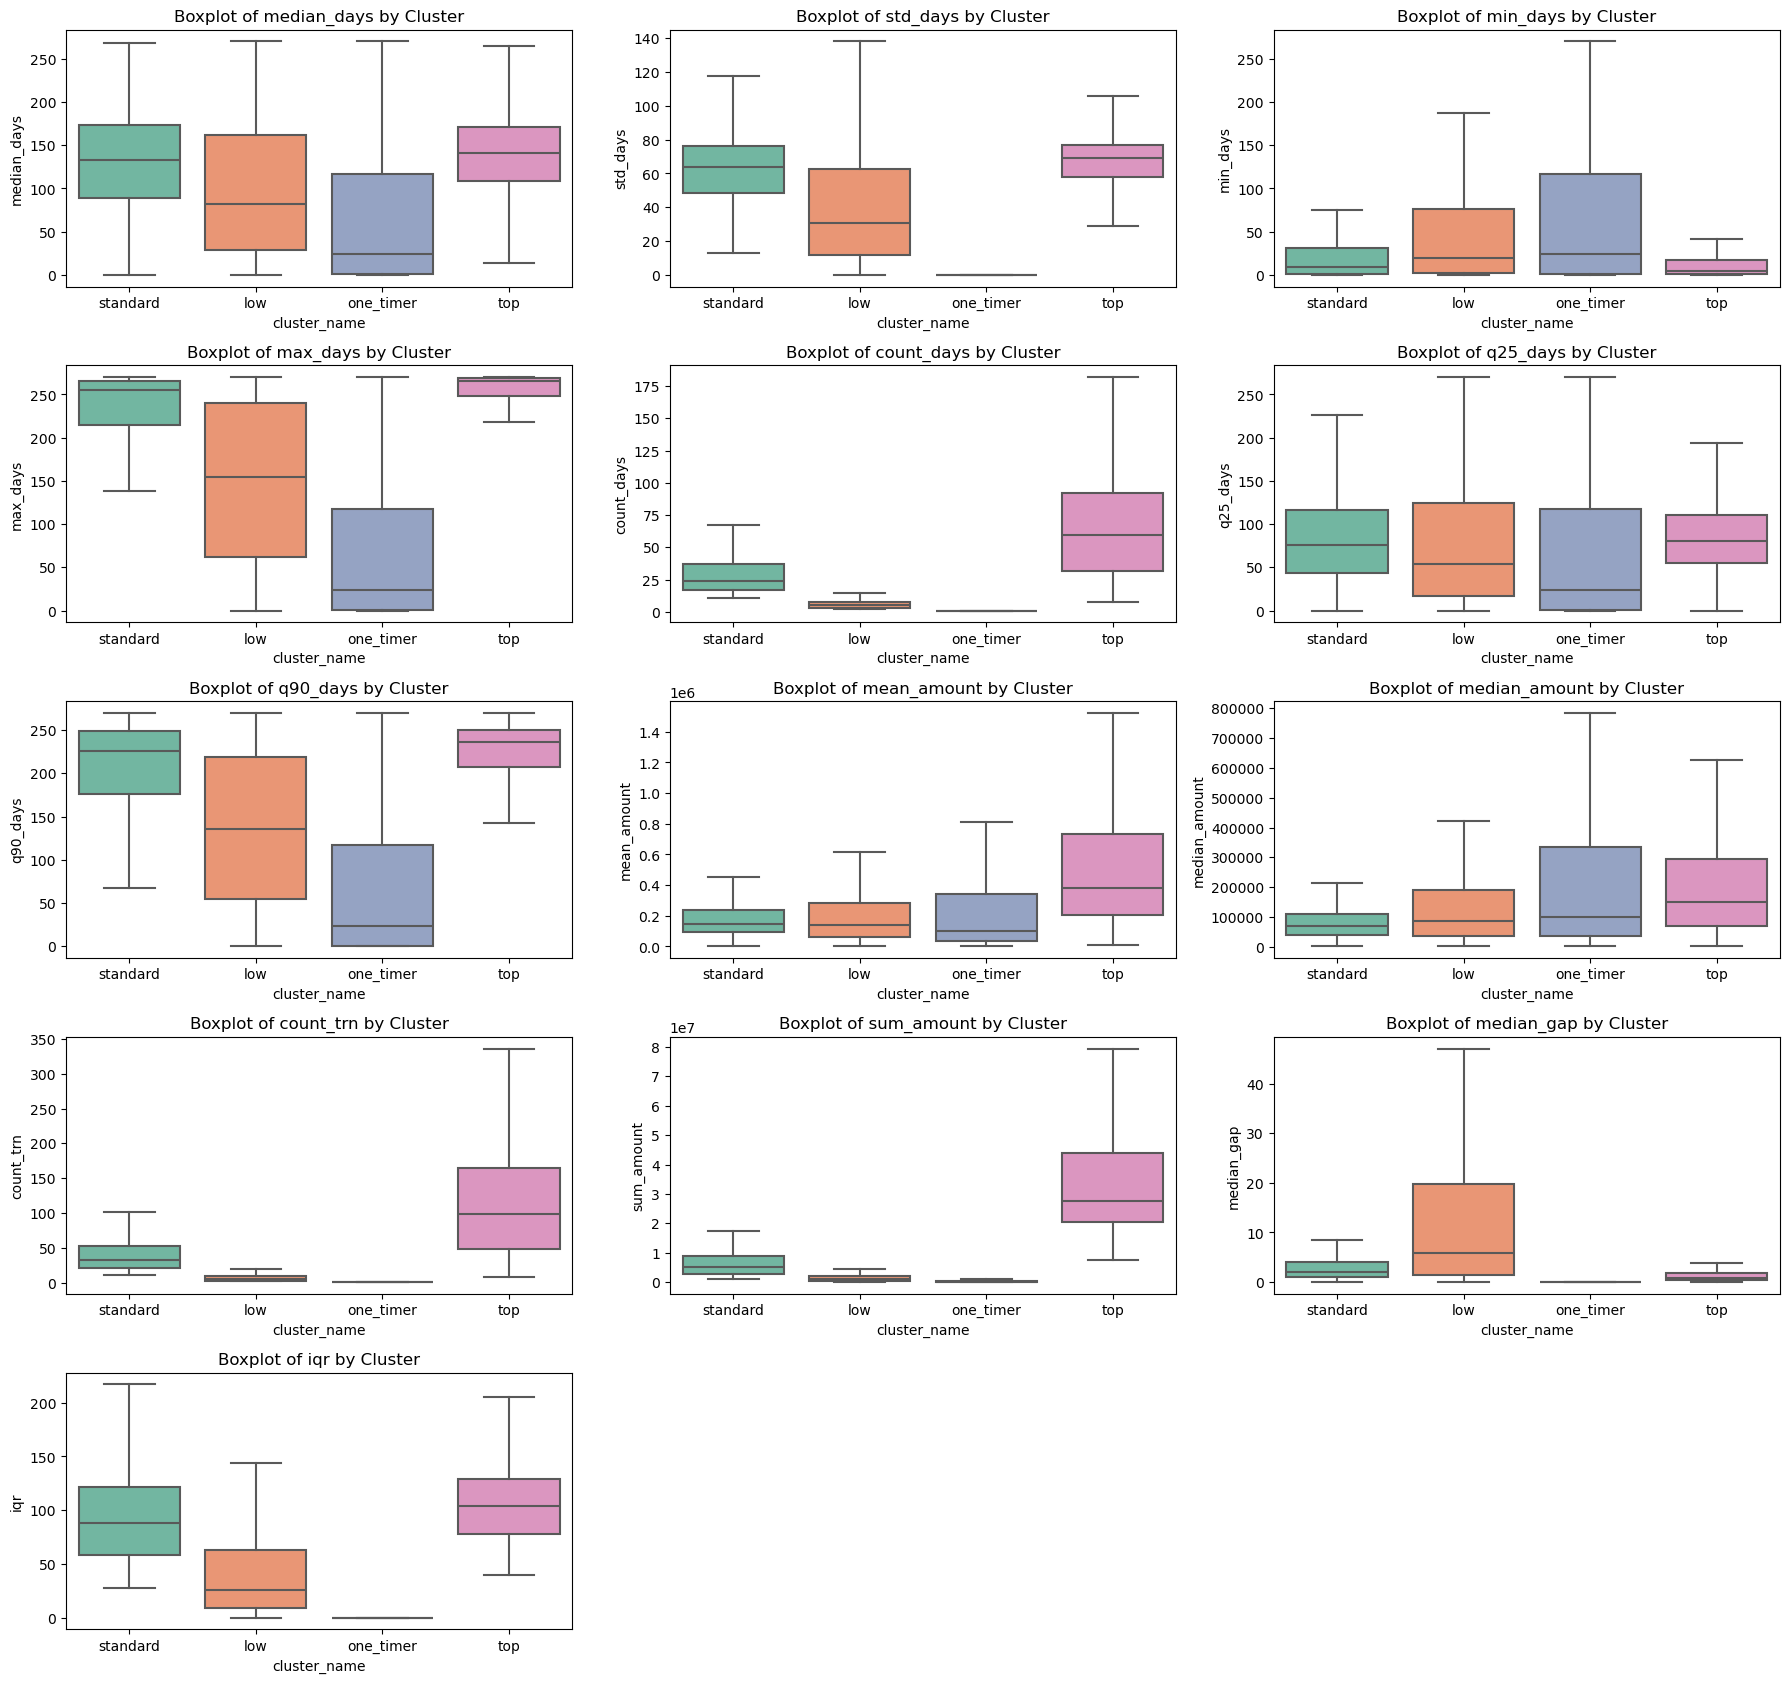

In [436]:
plt.figure(figsize=(18, 40))

# Create boxplots for each feature
for i, column in enumerate(col_list):
    plt.subplot(12, 3, i + 1)
    sns.boxplot(x='cluster_name', y=column, data=df_cluster, palette='Set2', showfliers=False)
    plt.title(f'Boxplot of {column} by Cluster')

plt.tight_layout()
plt.show()

In [437]:
col_list2 = ['count_days', 'mean_amount', 'sum_amount', 'iqr', 'cluster_name']
df_subset = df_cluster[col_list2]

C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

<Figure size 1000x1000 with 0 Axes>

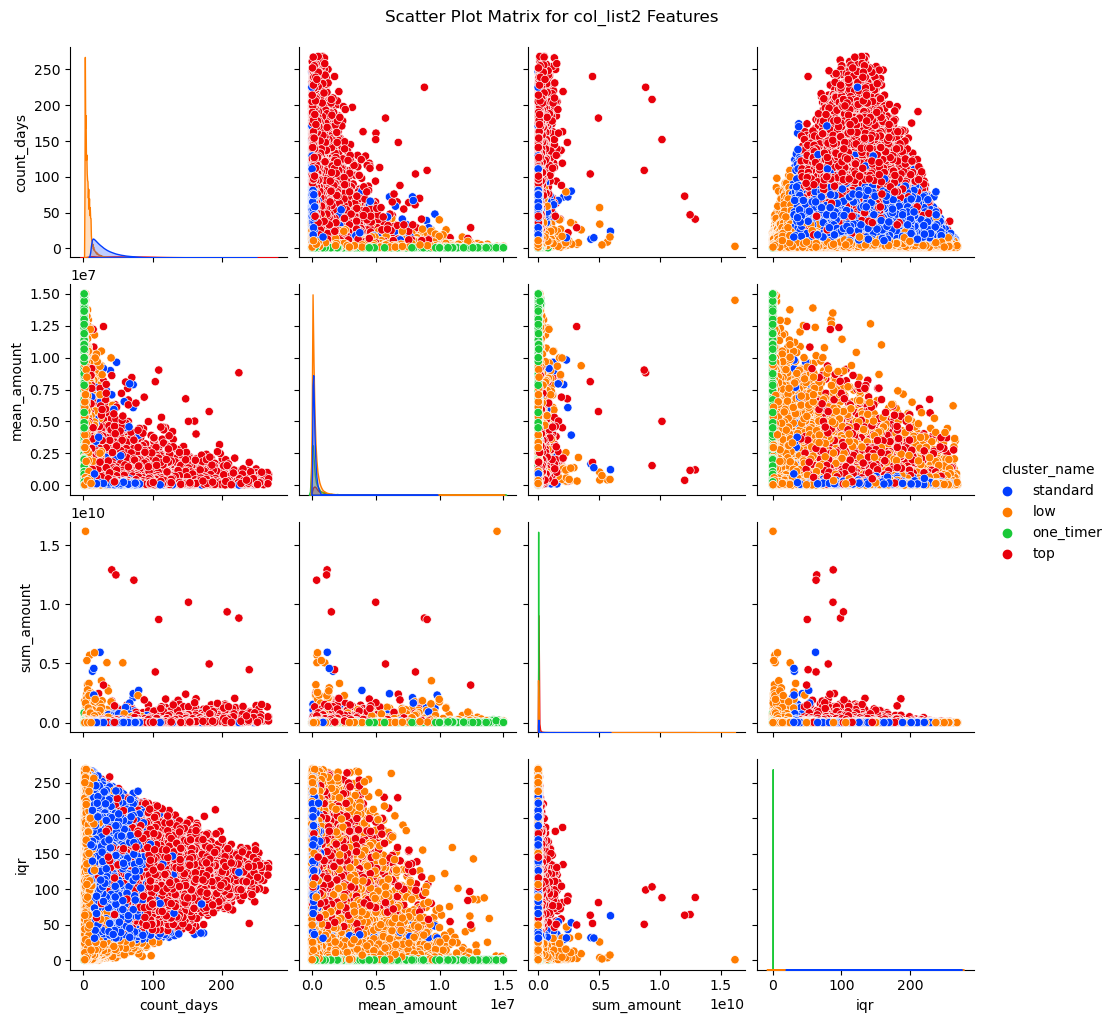

In [438]:
plt.figure(figsize=(10, 10))
sns.pairplot(df_subset, hue='cluster_name', palette = 'bright')
plt.suptitle('Scatter Plot Matrix for col_list2 Features', y=1.02)
plt.show()

In [439]:
#df_cluster.to_csv('df_cluster_refined.csv', index = False)

## Importing clusters

In [5]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)     

In [6]:
clusters = pd.read_csv('df_cluster_refined.csv')

In [7]:
clusters

payer_id   mean_days  median_days   std_days  \
0        63b087f13076e6f5fceb755b  148.060126   145.745499  55.742013   
1        63b088547a0fb9cdfc1be9df   57.187668    63.898614  51.934028   
2        63b0886f333a024f67172e87  118.072488   116.467817  62.225923   
3        63b089524a4163726fe294a8   42.130012    44.131635  20.516268   
4        63b089c7b154a9616f0aafe9  264.938804   264.938804   0.000000   
...                           ...         ...          ...        ...   
1694428  6609b2614a83c0ea62a6736e   65.956461    65.671598   0.495033   
1694429  6609b2651d688f7507395720  115.553545   124.385762  84.643942   
1694430  6609b29569264479907a9bea   75.532206    65.597293  57.670441   
1694431  6609b2a30e1e2157e76f436e  189.186411   192.770377  62.869378   
1694432  6609b2a3f1dac6569052ceb9   65.111386    64.563285  49.562331   

           min_days    max_days  count_days  skew_days  kurtosis_days  \
0         48.428718  251.579056          44   0.074310      -0.714368   
1          0.001893  109.353619           6  -0.142352      -2.871233   
2         35.587440  268.459435          12   0.927099       1.800084   
3          6.789640   70.733638          25  -0.068797      -1.255983   
4        264.938804  264.938804           1   0.000000       0.000000   
...             ...         ...         ...        ...            ...   
1694428   65.669710   66.528074           2   1.732022       0.000000   
1694429   20.657334  269.428003          11   0.425469      -1.446429   
1694430    5.840464  202.430387          19   0.900349       0.017136   
1694431  100.980987  261.815752           6  -0.264588      -1.285071   
1694432    0.044109  246.712016          11   3.300834      13.041012   

           q25_days    q75_days    q90_days    mean_amount  median_amount  \
0        114.251155  178.178971  230.958450   87691.176471        42500.0   
1          9.239341  102.189918  106.665221  102500.000000        70000.0   
2         85.285559  150.450269  163.522427   70769.230769        15000.0   
3         23.806355   57.456642   68.887924   53715.909091        39000.0   
4        264.938804  264.938804  264.938804  120000.000000       120000.0   
...             ...         ...         ...            ...            ...   
1694428   65.670654   66.099836   66.356779   33000.000000        35000.0   
1694429   39.590632  201.834813  220.575635   92711.368421        35000.0   
1694430   33.666247  123.647386  130.602949  116318.181818        31000.0   
1694431  148.895992  237.574924  256.314447  357333.333333        65000.0   
1694432   50.948138   64.929529   66.101239  138559.352941        65200.0   

         count_trn  sum_amount     std_amount  median_gap         iqr  \
0               68   5963000.0  112561.637821    0.896098   63.927816   
1                6    615000.0  115321.723886    7.147623   92.950577   
2               13    920000.0  104997.741123   11.540681   65.164710   
3               44   2363500.0   74589.371845    0.843067   33.650287   
4                1    120000.0       0.000000    0.000000    0.000000   
...            ...         ...            ...         ...         ...   
1694428          3     99000.0   15099.668871    0.429182    0.429182   
1694429         19   1761516.0  122570.535527    0.794425  162.244181   
1694430         22   2559000.0  167820.308199    3.066417   89.981139   
1694431          6   2144000.0  498984.034481   34.986840   88.678933   
1694432         17   2355509.0  155942.175414    0.918727   13.981391   

         variation  cluster  cluster_0_probability  cluster_1_probability  \
0        52.124170        0           9.998655e-01                    0.0   
1        11.272364        2           4.622788e-01                    0.0   
2        20.267724        2           9.874158e-01                    0.0   
3        28.687231        0           9.999729e-01                    0.0   
4         0.000000        1           1.597262e-10                    1.0   
...    

In [8]:
clusters[clusters.cluster_name == 'standard'].describe()

mean_days    median_days       std_days       min_days  \
count  439657.000000  439657.000000  439657.000000  439657.000000   
mean      130.225327     131.291273      61.896564      24.980395   
std        45.173502      55.565803      19.465213      37.459624   
min        13.715037       0.055707      12.749064       0.000362   
25%        98.755820      88.476211      48.176866       1.493887   
50%       133.063852     132.551160      63.970874       8.960446   
75%       162.129414     173.936255      76.042190      31.029477   
max       254.114586     268.325470     135.264736     234.889385   

            max_days     count_days      skew_days  kurtosis_days  \
count  439657.000000  439657.000000  439657.000000  439657.000000   
mean      230.912392      29.224295      -0.047748      -0.403354   
std        51.380803      16.749804       0.742118       1.708488   
min        31.900644      11.000000      -5.592914      -2.432777   
25%       214.938732      17.000000      -0.467244      -1.266487   
50%       255.432751      24.000000      -0.054316      -0.868797   
75%       266.112141      37.000000       0.369083      -0.175057   
max       269.999993     247.000000       5.053521      43.386740   

            q25_days       q75_days       q90_days   mean_amount  \
count  439657.000000  439657.000000  439657.000000  4.396570e+05   
mean       83.941174     177.270447     206.257935  1.861157e+05   
std        50.388024      55.583176      54.300416  1.571108e+05   
min         0.009733      28.601080      31.453975  3.446813e+03   
25%        43.897553     138.361729     175.907859  9.230000e+04   
50%        75.901093     189.113257     225.879642  1.484840e+05   
75%       116.685292     222.061007     248.497184  2.370500e+05   
max       239.228499     269.832054     269.973875  9.814966e+06   

       median_amount      count_trn    sum_amount    std_amount  \
count   4.396570e+05  439657.000000  4.396570e+05  4.396570e+05   
mean    9.246215e+04      42.798657  6.803212e+06  2.771958e+05   
std     9.811915e+04      44.629459  1.812459e+07  2.680418e+05   
min     1.000000e+03      11.000000  1.146000e+06  2.351682e+03   
25%     4.000000e+04      21.000000  2.907100e+06  1.174984e+05   
50%     7.000000e+04      33.000000  5.055000e+06  1.999058e+05   
75%     1.100000e+05      53.000000  8.743000e+06  3.440456e+05   
max     1.500000e+07   15071.000000  5.947879e+09  7.075834e+06   

          median_gap            iqr      variation   cluster  \
count  439657.000000  439657.000000  439657.000000  439657.0   
mean        3.075754      93.329273      41.104116       0.0   
std         2.906939      42.850680      18.713569       0.0   
min         0.000000      28.114235      15.813330       0.0   
25%         1.036430      58.603404      26.610955       0.0   
50%         2.052006      88.482424      36.395060       0.0   
75%         4.042520     122.027662      51.142659       0.0   
max        29.150701     266.209669     174.849811       0.0   

       cluster_0_probability  cluster_1_probability  cluster_2_probability  \
count          439657.000000               439657.0           4.396570e+05   
mean                0.956578                    0.0           1.199138e-03   
std                 0.174955                    0.0           1.598340e-02   
min                 0.000000                    0.0           0.000000e+00   
25%                 0.999115                    0.0          3.522985e-127   
50%                 0.999912                    0.0           2.817902e-46   
75%                 0.999962                    0.0           8.085598e-16   
max                 0.999988                    0.0           4.971300e-01   

       cluster_3_probability  max_probability_cluster  
count          439657.000000                 439657.0  
mean                0.042223                      0.0  
std                 0.174200                      0.0  
min                 0.000012                  

## Registration

In [9]:
reg = pd.read_sql("""
                select *
                from payme_sandbox.p2p_user_activation_reg
                """, con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_18504\4031718763.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  reg = pd.read_sql("""


In [10]:
reg['date_'] = pd.to_datetime(reg['date_'])

In [11]:
reg['day_of_week'] = reg['date_'].dt.dayofweek

In [12]:
conditions = [
    reg['distance_km'] < 15,
    reg['distance_km'] >= 15 
]
values = [1, 2]

reg['tashkent'] = np.select(conditions, values, default=0)

In [13]:
reg_c = pd.merge(reg, clusters[['payer_id', 'cluster_name']], how = 'inner', left_on = '_id', right_on = 'payer_id').drop(columns = ['payer_id'])

In [14]:
reg_cl = pd.get_dummies(reg_c, columns=['cluster_name'], dtype = 'int')
reg_cl['cluster_name'] = reg_c['cluster_name']

In [15]:
reg_cl_age = reg_cl[(reg_cl.age >= 14) & (reg_cl.age < 91)]

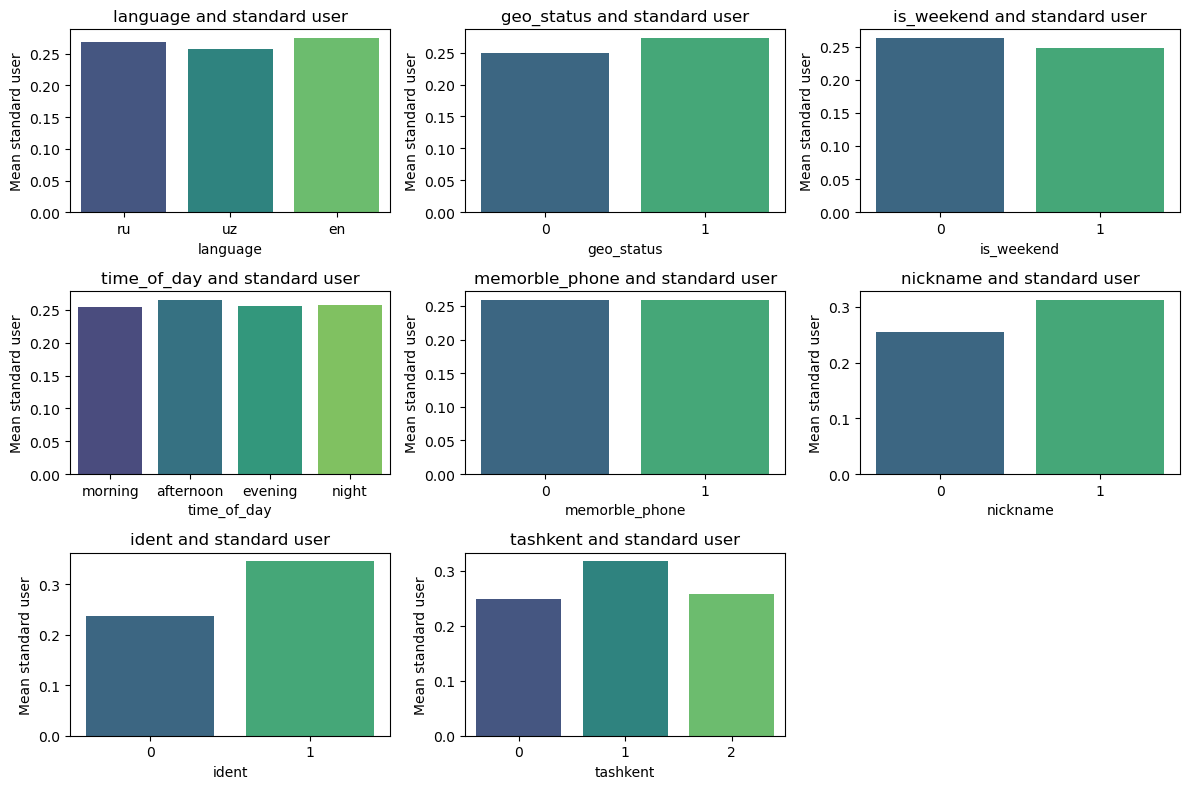

In [16]:
independent_features = ['language', 'geo_status', 'is_weekend', 'time_of_day', 'memorble_phone', 'nickname', 'ident', 'tashkent']

# Set up the plotting area
plt.figure(figsize=(12, 8))

# Loop through each independent feature to create a bar plot
for i, feature in enumerate(independent_features):
    plt.subplot(3, 3, i+1)  # Create a subplot for each feature
    sns.barplot(x=feature, y='cluster_name_standard', data=reg_cl, errorbar=None, palette='viridis')
    
    plt.title(f'{feature} and standard user')
    plt.ylabel('Mean standard user')  # Label the y-axis

plt.tight_layout()  # Adjust subplots to fit into figure area
plt.show()

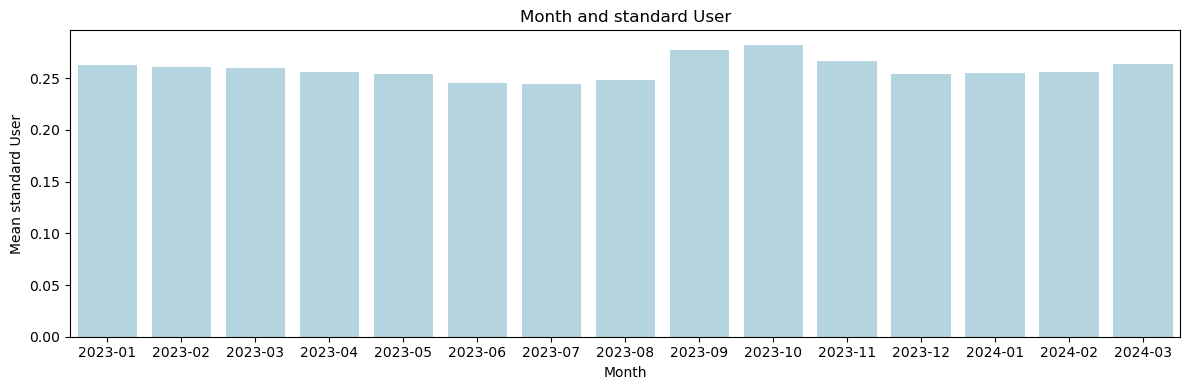

In [17]:
sorted_months = sorted(reg_cl['month_'].unique())

# Plotting the relationship between 'month_' and 'cluster_name_top'
plt.figure(figsize=(12, 4))

sns.barplot(
    x='month_', 
    y='cluster_name_standard', 
    data=reg_cl, 
    order=sorted_months, 
    errorbar=None, 
    color='lightblue'  # Set all bars to light blue
)

plt.title('Month and standard User')
plt.xlabel('Month')  # Label the x-axis
plt.ylabel('Mean standard User')  # Label the y-axis

# Set y-axis limits
#plt.ylim(0.06, 0.12)

plt.tight_layout()  # Adjust layout for better appearance
plt.show()

In [18]:
reg_cl.head()

_id                            date_   month_  \
0  64f6cc365d6e00d999f6b386 2023-09-05 06:35:34.725000+00:00  2023-09   
1  63b93fdd3bd4a787c31c0420 2023-01-07 09:48:13.414000+00:00  2023-01   
2  65d31ce1f77e80ecc3f618b5 2024-02-19 09:18:25.801000+00:00  2024-02   
3  64f9558290190f4dcd5fb0b5 2023-09-07 04:45:54.448000+00:00  2023-09   
4  65698e7b4b9ae7ab3d858146 2023-12-01 07:42:51.452000+00:00  2023-12   

  language  geo_status  is_weekend time_of_day  memorble_phone  distance_km  \
0       ru           0           0     morning               0          NaN   
1       uz           0           1   afternoon               0          NaN   
2       uz           1           0   afternoon               0   298.400006   
3       uz           0           0     morning               0          NaN   
4       uz           0           0   afternoon               0          NaN   

   nickname  ident   age  day_of_week  tashkent  cluster_name_low  \
0         0      1  33.0            1         0                 0   
1         0      0   NaN            5         0                 1   
2         0      0   NaN            0         2                 1   
3         0      0   NaN            3         0                 0   
4         0      0   NaN            4         0                 1   

   cluster_name_one_timer  cluster_name_standard  cluster_name_top  \
0                       0                      0                 1   
1                       0                      0                 0   
2                       0                      0                 0   
3                       0                      1                 0   
4                       0                      0                 0   

  cluster_name  
0          top  
1          low  
2          low  
3     standard  
4          low

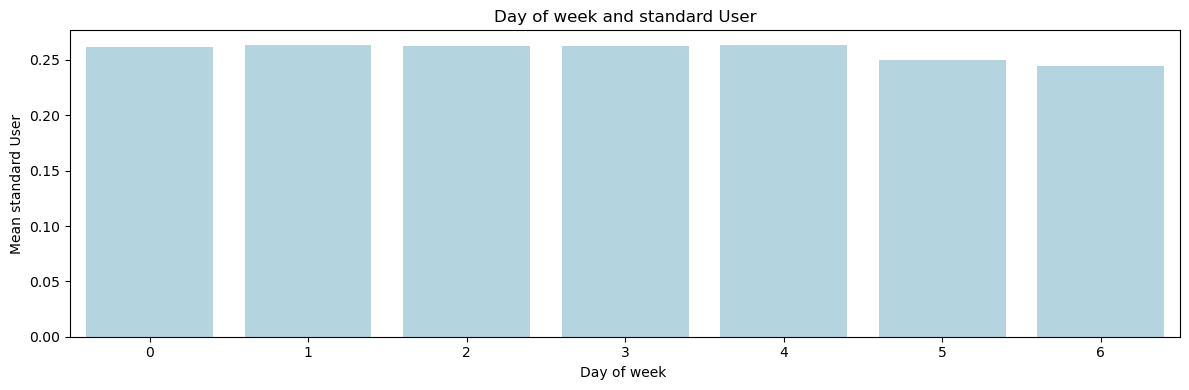

In [19]:
plt.figure(figsize=(12, 4))

sns.barplot(
    x='day_of_week', 
    y='cluster_name_standard', 
    data=reg_cl, 
    errorbar=None, 
    color='lightblue'  # Set all bars to light blue
)

plt.title('Day of week and standard User')
plt.xlabel('Day of week ')  # Label the x-axis
plt.ylabel('Mean standard User')  # Label the y-axis

# Set y-axis limits
#plt.ylim(0, 0.12)

plt.tight_layout()  # Adjust layout for better appearance
plt.show()

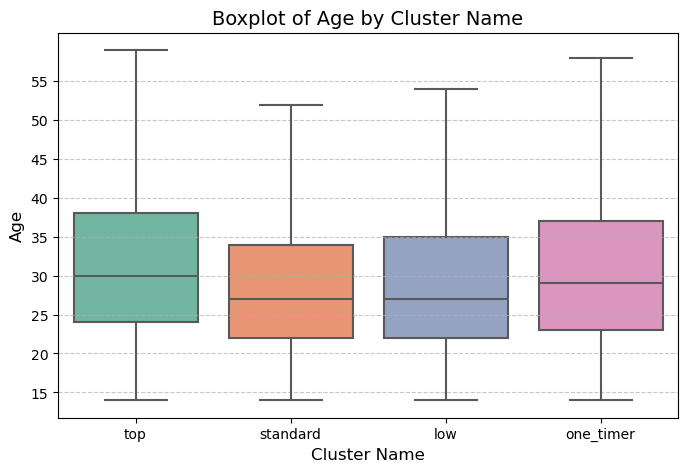

In [20]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=reg_cl_age, x='cluster_name', y='age', palette='Set2', showfliers=False)

yticks = np.arange(15, 60, 5) 
plt.yticks(yticks)

# Customize the plot.
plt.title('Boxplot of Age by Cluster Name', fontsize=14)
plt.xlabel('Cluster Name', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Devices

In [21]:
dev = pd.read_sql("""
select *
from
(
select *, row_number() over (partition by user_id order by date_) rn
from
    (
    select user_id, lower(regexp_replace(split_part(display, ' ', 1), '[0-9,]', '', 'g')) model, lower(agent_os_name) os, raw_data -> 'agent' -> 'app' ->> 'theme' theme, date date_
    from ods__mdbmn__payme.devices
    union all
    select user_id, lower(regexp_replace(split_part(display, ' ', 1), '[0-9,]', '', 'g')) model, lower(agent_os_name) os, raw_data -> 'agent' -> 'app' ->> 'theme' theme, date_time date_
    from ods__mdbmn__payme.devices_archive
    ) d1
) d2
where rn = 1
""", con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_18504\4223986124.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dev = pd.read_sql("""


In [22]:
dev_cl = pd.merge(dev, clusters[['payer_id', 'cluster_name']], how = 'inner', left_on = 'user_id', right_on = 'payer_id').drop(columns = ['payer_id'])

dev_cld = pd.get_dummies(dev_cl, columns=['cluster_name'], dtype = 'int')
dev_cld['cluster_name'] = dev_cl['cluster_name']

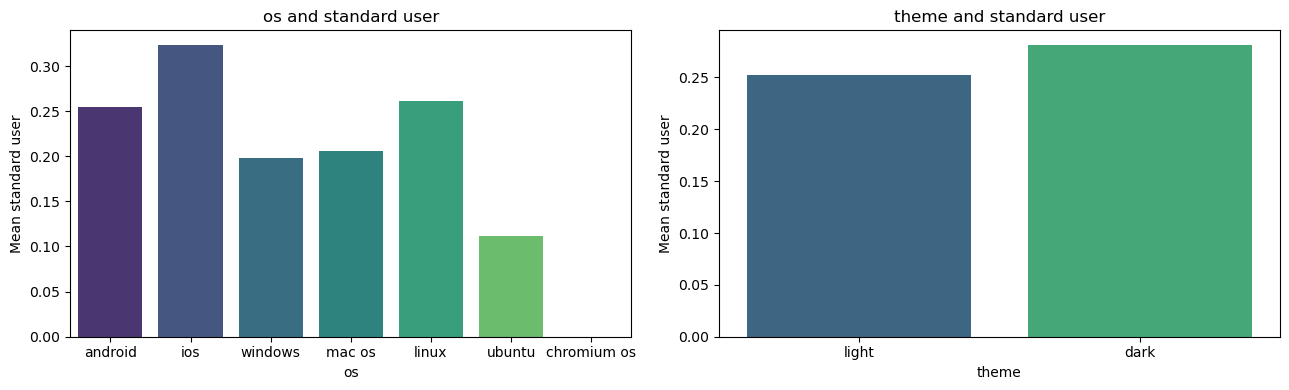

In [23]:
independent_features = ['os', 'theme']

# Set up the plotting area
plt.figure(figsize=(13, 4))

# Loop through each independent feature to create a bar plot
for i, feature in enumerate(independent_features):
    plt.subplot(1, 2, i+1)  # Create a subplot for each feature
    sns.barplot(x=feature, y='cluster_name_standard', data=dev_cld, errorbar=None, palette='viridis')
    
    plt.title(f'{feature} and standard user')
    plt.ylabel('Mean standard user')  # Label the y-axis

plt.tight_layout()  # Adjust subplots to fit into figure area
plt.show()

In [24]:
dev_cld.groupby('os')['user_id'].count()

os
android        1494083
chromium os          1
ios             175110
linux              134
mac os             228
ubuntu               9
windows           5295
Name: user_id, dtype: int64

In [25]:
models = dev_cld.groupby('model')['user_id'].count().reset_index().sort_values('user_id', ascending = False).head(10)['model']

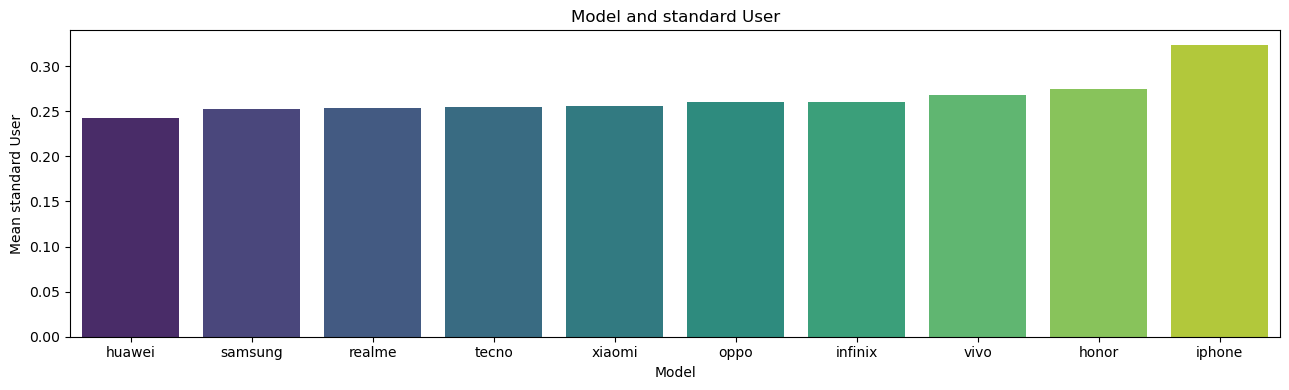

In [26]:
sorted_data = (
    dev_cld[dev_cld['model'].isin(models)]
    .groupby('model', as_index=False)['cluster_name_standard']
    .mean()
    .sort_values(by='cluster_name_standard')
)

plt.figure(figsize=(13, 4))
sns.barplot(
    x='model', 
    y='cluster_name_standard', 
    data=sorted_data, 
    errorbar=None, 
    palette='viridis'
)

plt.title(f'Model and standard User')
plt.ylabel('Mean standard User')
plt.xlabel('Model')

plt.tight_layout()  
plt.show()

## Sessions

In [27]:
ses = pd.read_sql("""
        select user_id, session_date_1, session_date_2,
            extract(epoch from (session_date_2 - session_date_1))/60/60 second_session_hours,
            extract(epoch from (session_date_5 - session_date_1))/60/60/24 fifth_session_days,
            extract(epoch from (session_date_10 - session_date_1))/60/60/24 tenth_session_days,
            case when session_date_5 is null then 0 else 1 end fifth_session_flg,
            case when session_date_10 is null then 0 else 1 end tenth_session_flg,
            returned_next_day,
            day_sessions::numeric/(day_sessions + night_sessions)::numeric day_sessions_share, sessions_count
        from payme_sandbox.p2p_user_activation_sessions_
""", con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_18504\1486783933.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ses = pd.read_sql("""


In [28]:
week = pd.read_sql("""
        select *
        from payme_sandbox.p2p_user_activation_sessions_day_of_week
""", con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_18504\2400564199.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  week = pd.read_sql("""


In [29]:
hour = pd.read_sql("""
        select *
        from payme_sandbox.p2p_user_activation_sessions_hour_of_day
""", con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_18504\4150690652.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hour = pd.read_sql("""


In [30]:
day = pd.read_sql("""
        select *
        from payme_sandbox.p2p_user_activation_sessions_day_of_month
""", con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_18504\2654121714.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  day = pd.read_sql("""


In [31]:
ses_cl = pd.merge(ses, clusters[['payer_id', 'cluster_name']], how = 'inner', left_on = 'user_id', right_on = 'payer_id').drop(columns = ['payer_id'])

ses_cld = pd.get_dummies(ses_cl, columns=['cluster_name'], dtype = 'int')
ses_cld['cluster_name'] = ses_cl['cluster_name']

In [32]:
ses_cld = pd.get_dummies(ses_cl, columns=['cluster_name'], dtype = 'int')
ses_cld['cluster_name'] = ses_cl['cluster_name']

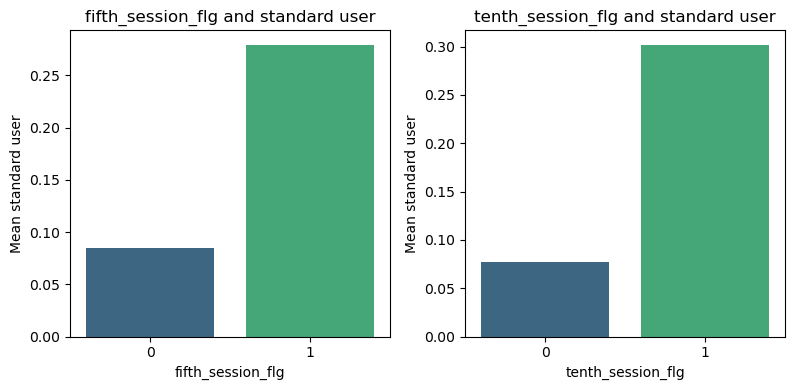

In [33]:
independent_features = ['fifth_session_flg', 'tenth_session_flg']

# Set up the plotting area
plt.figure(figsize=(12, 4))

# Loop through each independent feature to create a bar plot
for i, feature in enumerate(independent_features):
    plt.subplot(1, 3, i+1)  
    sns.barplot(x=feature, y='cluster_name_standard', data=ses_cld, errorbar=None, palette='viridis')
    
    plt.title(f'{feature} and standard user')
    plt.ylabel('Mean standard user')  

plt.tight_layout()  
plt.show()

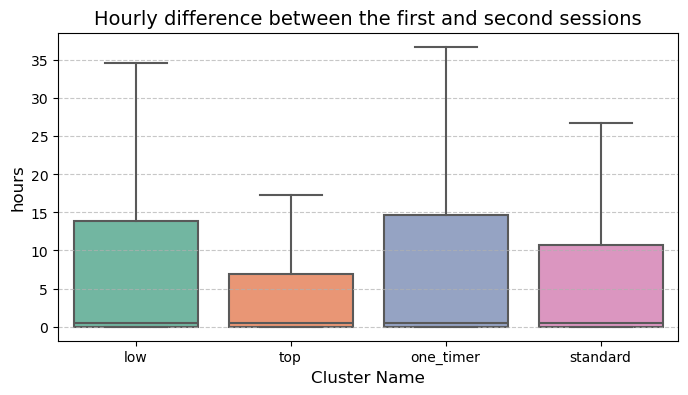

In [34]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=ses_cld.dropna(subset='second_session_hours'), x='cluster_name', y='second_session_hours', palette='Set2', showfliers=False)

# Customize the plot.
plt.title('Hourly difference between the first and second sessions', fontsize=14)
plt.xlabel('Cluster Name', fontsize=12)
plt.ylabel('hours', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

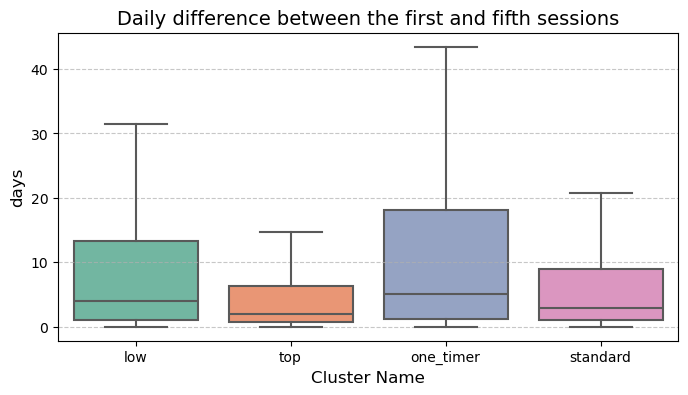

In [35]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=ses_cld.dropna(subset='fifth_session_days'), x='cluster_name', y='fifth_session_days', palette='Set2', showfliers=False)

# Customize the plot.
plt.title('Daily difference between the first and fifth sessions', fontsize=14)
plt.xlabel('Cluster Name', fontsize=12)
plt.ylabel('days', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

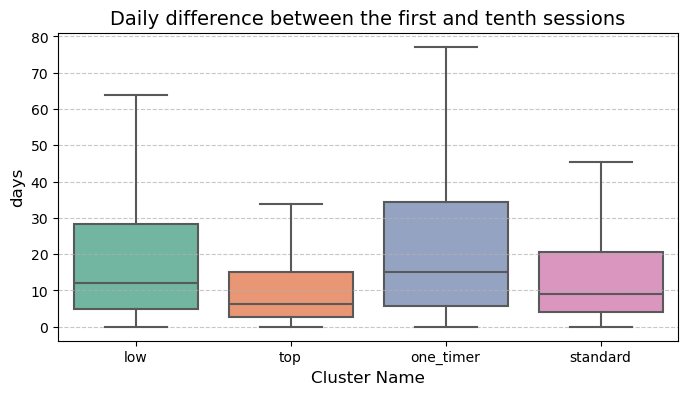

In [36]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=ses_cld.dropna(subset='tenth_session_days'), x='cluster_name', y='tenth_session_days', palette='Set2', showfliers=False)

# Customize the plot.
plt.title('Daily difference between the first and tenth sessions', fontsize=14)
plt.xlabel('Cluster Name', fontsize=12)
plt.ylabel('days', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [37]:
week_cl = pd.merge(week, clusters[['payer_id', 'cluster_name']], how = 'inner', left_on = 'user_id', right_on = 'payer_id').drop(columns = ['payer_id'])

In [38]:
week_cld = pd.get_dummies(week_cl, columns=['cluster_name'], dtype = 'int')
week_cld['cluster_name'] = week_cl['cluster_name']

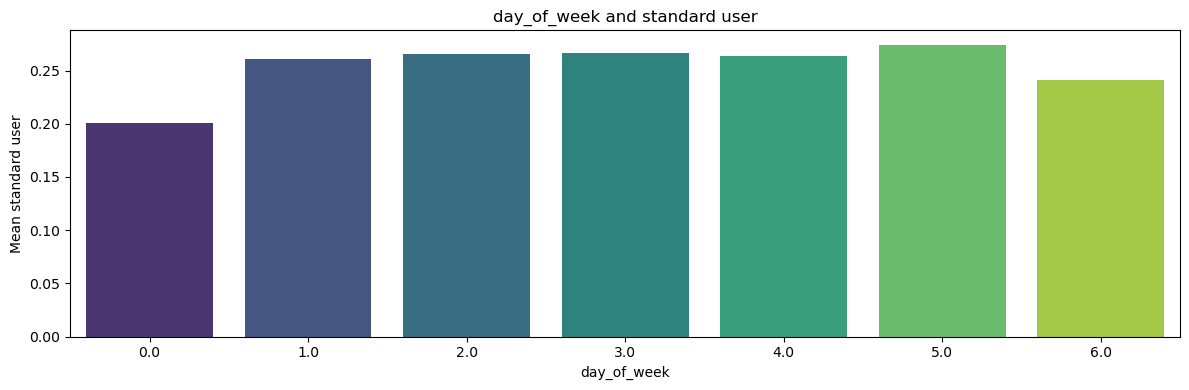

In [39]:
plt.figure(figsize=(12, 4))

sns.barplot(x='day_of_week', y='cluster_name_standard', data=week_cld, errorbar=None, palette='viridis')

plt.title('day_of_week and standard user')
plt.ylabel('Mean standard user')  

plt.tight_layout()  
plt.show()

In [40]:
hour_cl = pd.merge(hour, clusters[['payer_id', 'cluster_name']], how = 'inner', left_on = 'user_id', right_on = 'payer_id').drop(columns = ['payer_id'])

In [41]:
hour_cld = pd.get_dummies(hour_cl, columns=['cluster_name'], dtype = 'int')
hour_cld['cluster_name'] = hour_cl['cluster_name']

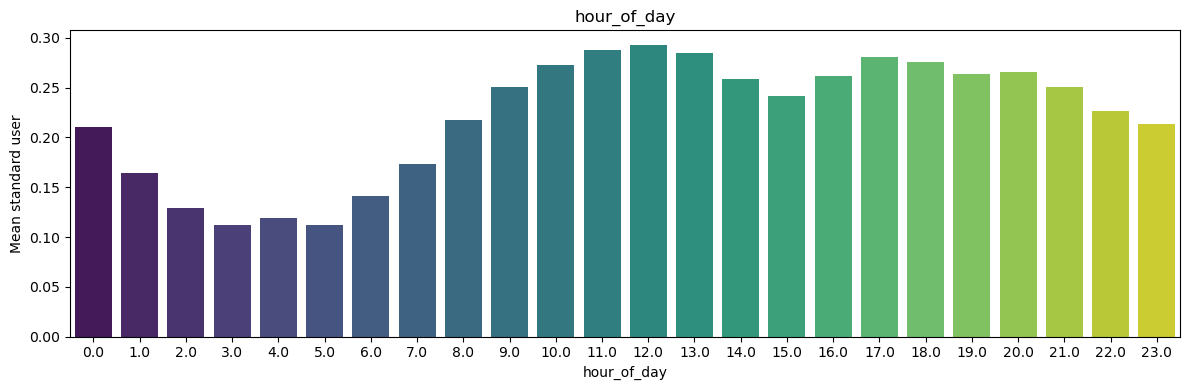

In [42]:
plt.figure(figsize=(12, 4))

sns.barplot(x='hour_of_day', y='cluster_name_standard', data=hour_cld, errorbar=None, palette='viridis')

plt.title('hour_of_day')
plt.ylabel('Mean standard user')  

plt.tight_layout()  
plt.show()

In [43]:
day_cl = pd.merge(day, clusters[['payer_id', 'cluster_name']], how = 'inner', left_on = 'user_id', right_on = 'payer_id').drop(columns = ['payer_id'])

In [44]:
day_cld = pd.get_dummies(day_cl, columns=['cluster_name'], dtype = 'int')
day_cld['cluster_name'] = day_cl['cluster_name']

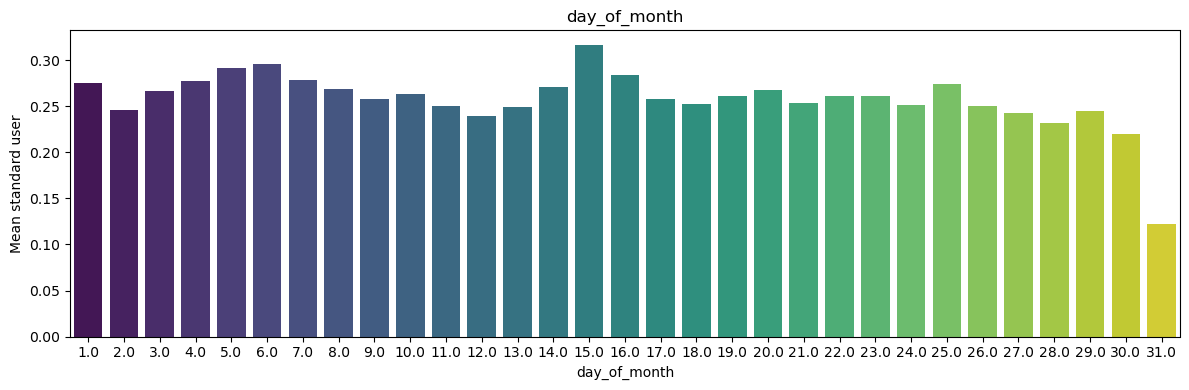

In [45]:
plt.figure(figsize=(12, 4))

sns.barplot(x='day_of_month', y='cluster_name_standard', data=day_cld, errorbar=None, palette='viridis')

plt.title('day_of_month')
plt.ylabel('Mean standard user')  

plt.tight_layout()  
plt.show()

In [46]:
ses7 = pd.read_sql("""select * from payme_sandbox.p2p_user_activation_sessions_7""", con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_18504\3918431715.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ses7 = pd.read_sql("""select * from payme_sandbox.p2p_user_activation_sessions_7""", con = conn)


In [47]:
ses7_cl = pd.merge(ses7, clusters[['payer_id', 'cluster_name']], how = 'left', left_on = 'user_id', right_on = 'payer_id').drop(columns = ['payer_id'])

ses7_cld = pd.get_dummies(ses7_cl, columns=['cluster_name'], dtype = 'int')
ses7_cld['cluster_name'] = ses7_cl['cluster_name']

C:\Users\MSI\AppData\Local\Temp\ipykernel_18504\726040536.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  probabilities = ses7_cld.groupby('sessions_count_bin')['cluster_name_standard'].mean().reset_index()
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


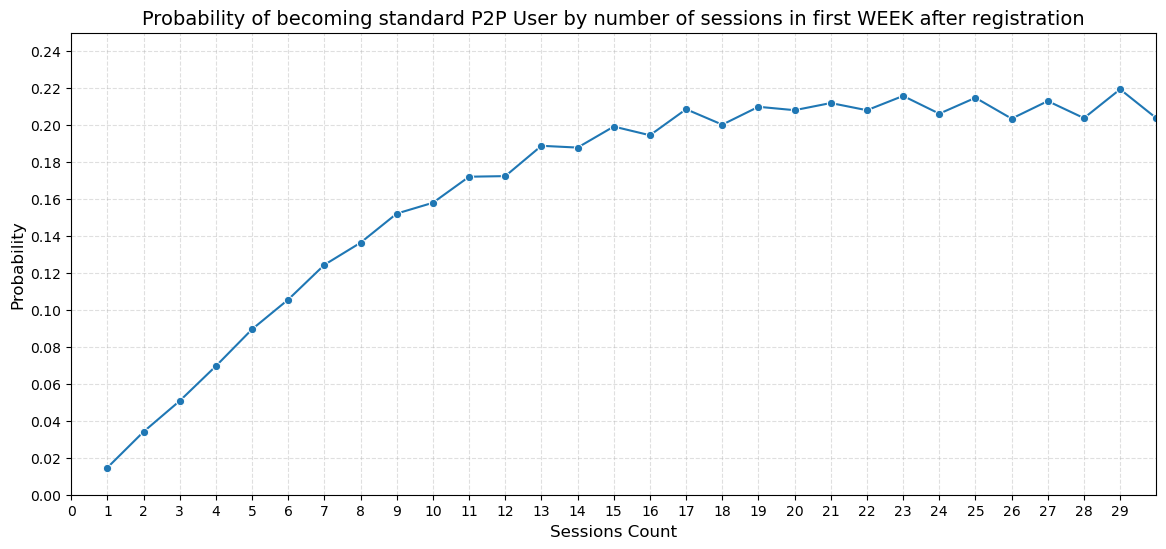

In [48]:
step_size = 1
ses7_cld['sessions_count_bin'] = pd.cut(
    ses7_cld['sessions_count'],
    bins=np.arange(0, ses7_cld['sessions_count'].max() + step_size, step_size),
    right=False,
    labels=np.arange(0, ses7_cld['sessions_count'].max(), step_size),
)

probabilities = ses7_cld.groupby('sessions_count_bin')['cluster_name_standard'].mean().reset_index()
probabilities.columns = ['sessions_count_bin', 'probability_cluster_name_standard_1']

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=probabilities, 
    x='sessions_count_bin', 
    y='probability_cluster_name_standard_1', 
    marker='o'
)
plt.title('Probability of becoming standard P2P User by number of sessions in first WEEK after registration', fontsize=14)
plt.xlabel('Sessions Count', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xlim(0, 30)
plt.ylim(0, 0.25)
plt.xticks(np.arange(0, 30, 1))
plt.yticks(np.arange(0, 0.25, 0.02))
plt.grid(visible=True, linestyle='--', alpha=0.4)
plt.show()


In [49]:
ses30 = pd.read_sql("""select * from payme_sandbox.p2p_user_activation_sessions_30""", con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_18504\4135239948.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ses30 = pd.read_sql("""select * from payme_sandbox.p2p_user_activation_sessions_30""", con = conn)


In [50]:
ses30_cl = pd.merge(ses30, clusters[['payer_id', 'cluster_name']], how = 'left', left_on = 'user_id', right_on = 'payer_id').drop(columns = ['payer_id'])

ses30_cld = pd.get_dummies(ses30_cl, columns=['cluster_name'], dtype = 'int')
ses30_cld['cluster_name'] = ses30_cl['cluster_name']

C:\Users\MSI\AppData\Local\Temp\ipykernel_18504\2558861652.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  probabilities = ses30_cld.groupby('sessions_count_bin')['cluster_name_standard'].mean().reset_index()
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


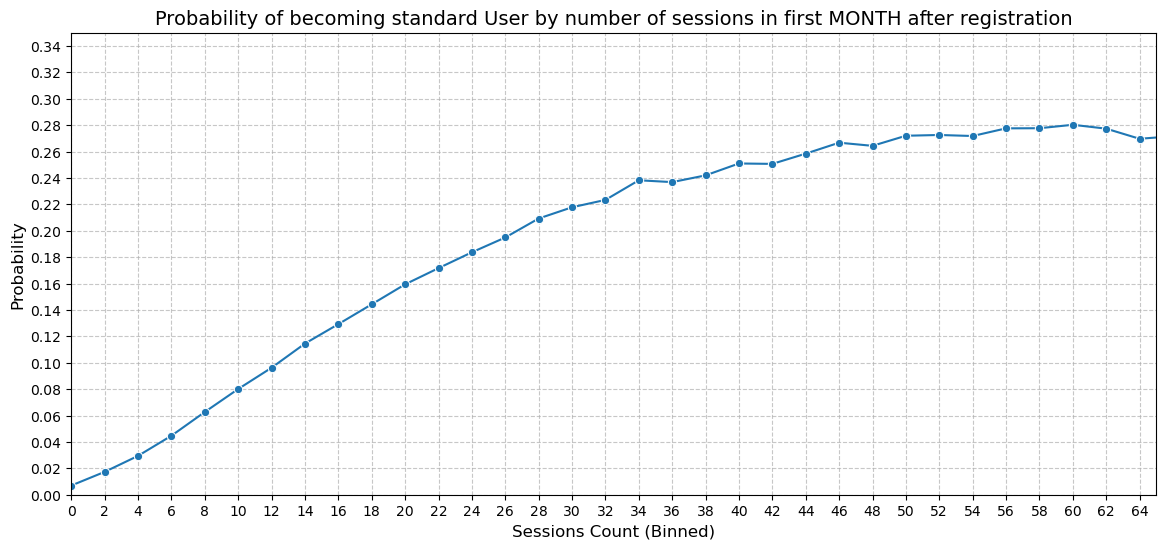

In [51]:
step_size = 2
ses30_cld['sessions_count_bin'] = pd.cut(
    ses30_cld['sessions_count'],
    bins=np.arange(0, ses30_cld['sessions_count'].max() + step_size, step_size),
    right=False,
    labels=np.arange(0, ses30_cld['sessions_count'].max(), step_size),
)

probabilities = ses30_cld.groupby('sessions_count_bin')['cluster_name_standard'].mean().reset_index()
probabilities.columns = ['sessions_count_bin', 'probability_cluster_name_standard_1']

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=probabilities, 
    x='sessions_count_bin', 
    y='probability_cluster_name_standard_1', 
    marker='o'
)
plt.title('Probability of becoming standard User by number of sessions in first MONTH after registration', fontsize=14)
plt.xlabel('Sessions Count (Binned)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xlim(0, 65)
plt.ylim(0, 0.35)
plt.xticks(np.arange(0, 65, 2))
plt.yticks(np.arange(0, 0.35, 0.02))
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.show()


In [52]:
ses24 = pd.read_sql("""select * from payme_sandbox.p2p_user_activation_sessions_24""", con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_18504\3223627244.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ses24 = pd.read_sql("""select * from payme_sandbox.p2p_user_activation_sessions_24""", con = conn)


In [53]:
ses24_cl = pd.merge(ses24, clusters[['payer_id', 'cluster_name']], how = 'left', left_on = 'user_id', right_on = 'payer_id').drop(columns = ['payer_id'])

ses24_cld = pd.get_dummies(ses24_cl, columns=['cluster_name'], dtype = 'int')
ses24_cld['cluster_name'] = ses24_cl['cluster_name']

C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


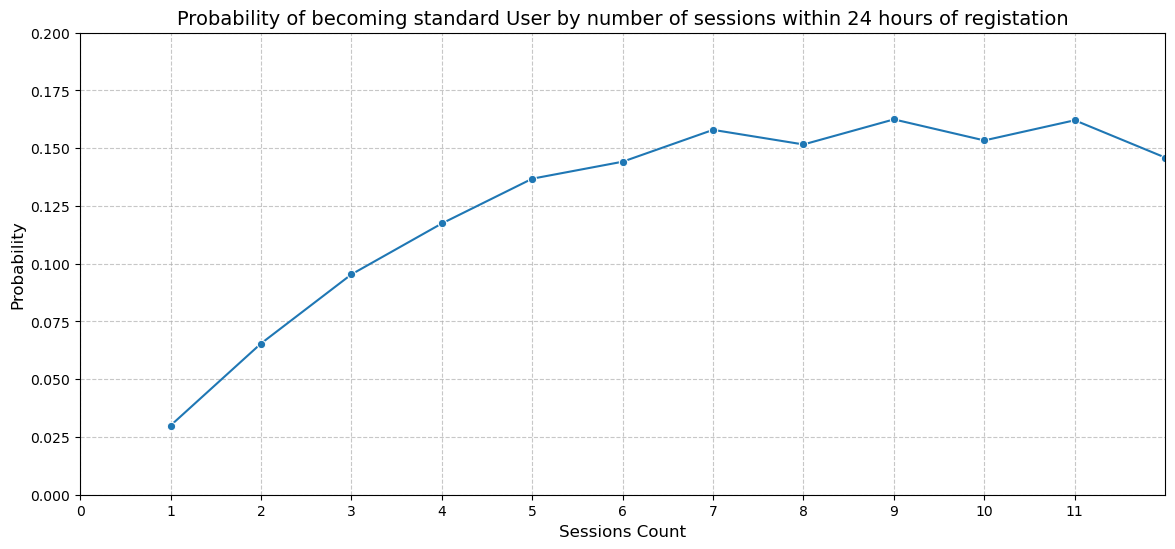

In [54]:
probabilities = ses24_cld.groupby('sessions_count')['cluster_name_standard'].mean().reset_index()
probabilities.columns = ['sessions_count', 'probability_cluster_name_standard_1']

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=probabilities, 
    x='sessions_count', 
    y='probability_cluster_name_standard_1', 
    marker='o'
)
plt.title('Probability of becoming standard User by number of sessions within 24 hours of registation', fontsize=14)
plt.xlabel('Sessions Count', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.xlim(0, 12)
plt.ylim(0, 0.2)
plt.xticks(np.arange(0, 12, 1))
plt.show()


## Cards

In [55]:
cards = pd.read_sql("""
        select * from payme_sandbox.p2p_user_activation_cards
""", con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_18504\3541958526.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cards = pd.read_sql("""


In [56]:
cards_cl = pd.merge(cards, clusters[['payer_id', 'cluster_name']], how = 'inner', left_on = 'user_id', right_on = 'payer_id').drop(columns = ['payer_id'])

In [57]:
cards_cld = pd.get_dummies(cards_cl, columns=['cluster_name'], dtype = 'int')
cards_cld['cluster_name'] = cards_cl['cluster_name']

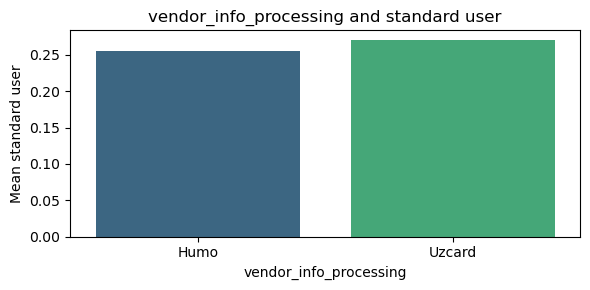

In [58]:
plt.figure(figsize=(6, 3))

sns.barplot(x='vendor_info_processing', y='cluster_name_standard', data=cards_cld, errorbar=None, palette='viridis')

plt.title('vendor_info_processing and standard user')
plt.ylabel('Mean standard user')  

plt.tight_layout()  
plt.show()

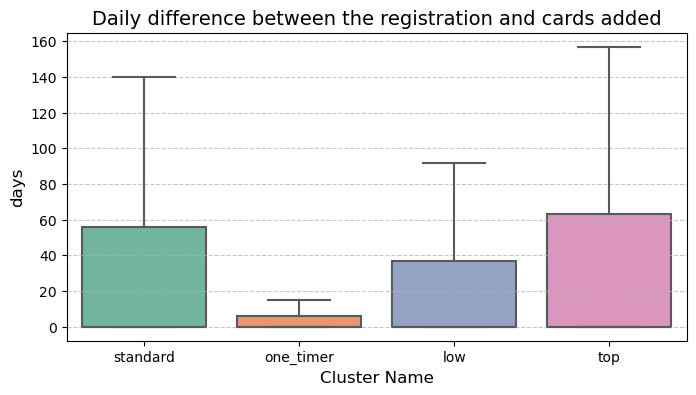

In [59]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=cards_cld, x='cluster_name', y='card_add_days', palette='Set2', showfliers=False)

# Customize the plot.
plt.title('Daily difference between the registration and cards added', fontsize=14)
plt.xlabel('Cluster Name', fontsize=12)
plt.ylabel('days', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Payments

In [62]:
p2p_tran = pd.read_csv('p2p_transactions.csv')

In [63]:
tran = p2p_tran[p2p_tran.tr_type != 'p2p']

In [64]:
tran_cl = pd.merge(tran, clusters[['payer_id', 'cluster_name']], how = 'inner', on = 'payer_id')

In [65]:
tran_cld = pd.get_dummies(tran_cl, columns=['cluster_name'], dtype = 'int')
tran_cld['cluster_name'] = tran_cl['cluster_name']

In [66]:
cl_user_size = clusters.groupby('cluster_name')['payer_id'].nunique().reset_index().rename(columns = {'payer_id':'total_users'})

In [67]:
tran_cl_grouped = tran_cl.groupby(['cluster_name', 'tr_type']).agg({'payer_id': 'nunique', 'amount': 'sum'}).reset_index()

In [68]:
tran_cl_grouped = tran_cl_grouped.merge(cl_user_size, how = 'inner', on = 'cluster_name')

In [69]:
tran_cl_grouped['intersection_with_transfers'] = 100*tran_cl_grouped['payer_id'] / tran_cl_grouped['total_users']

In [70]:
tran_cl_grouped.tr_type.nunique()

24

C:\Users\MSI\AppData\Local\Temp\ipykernel_18648\3582640122.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


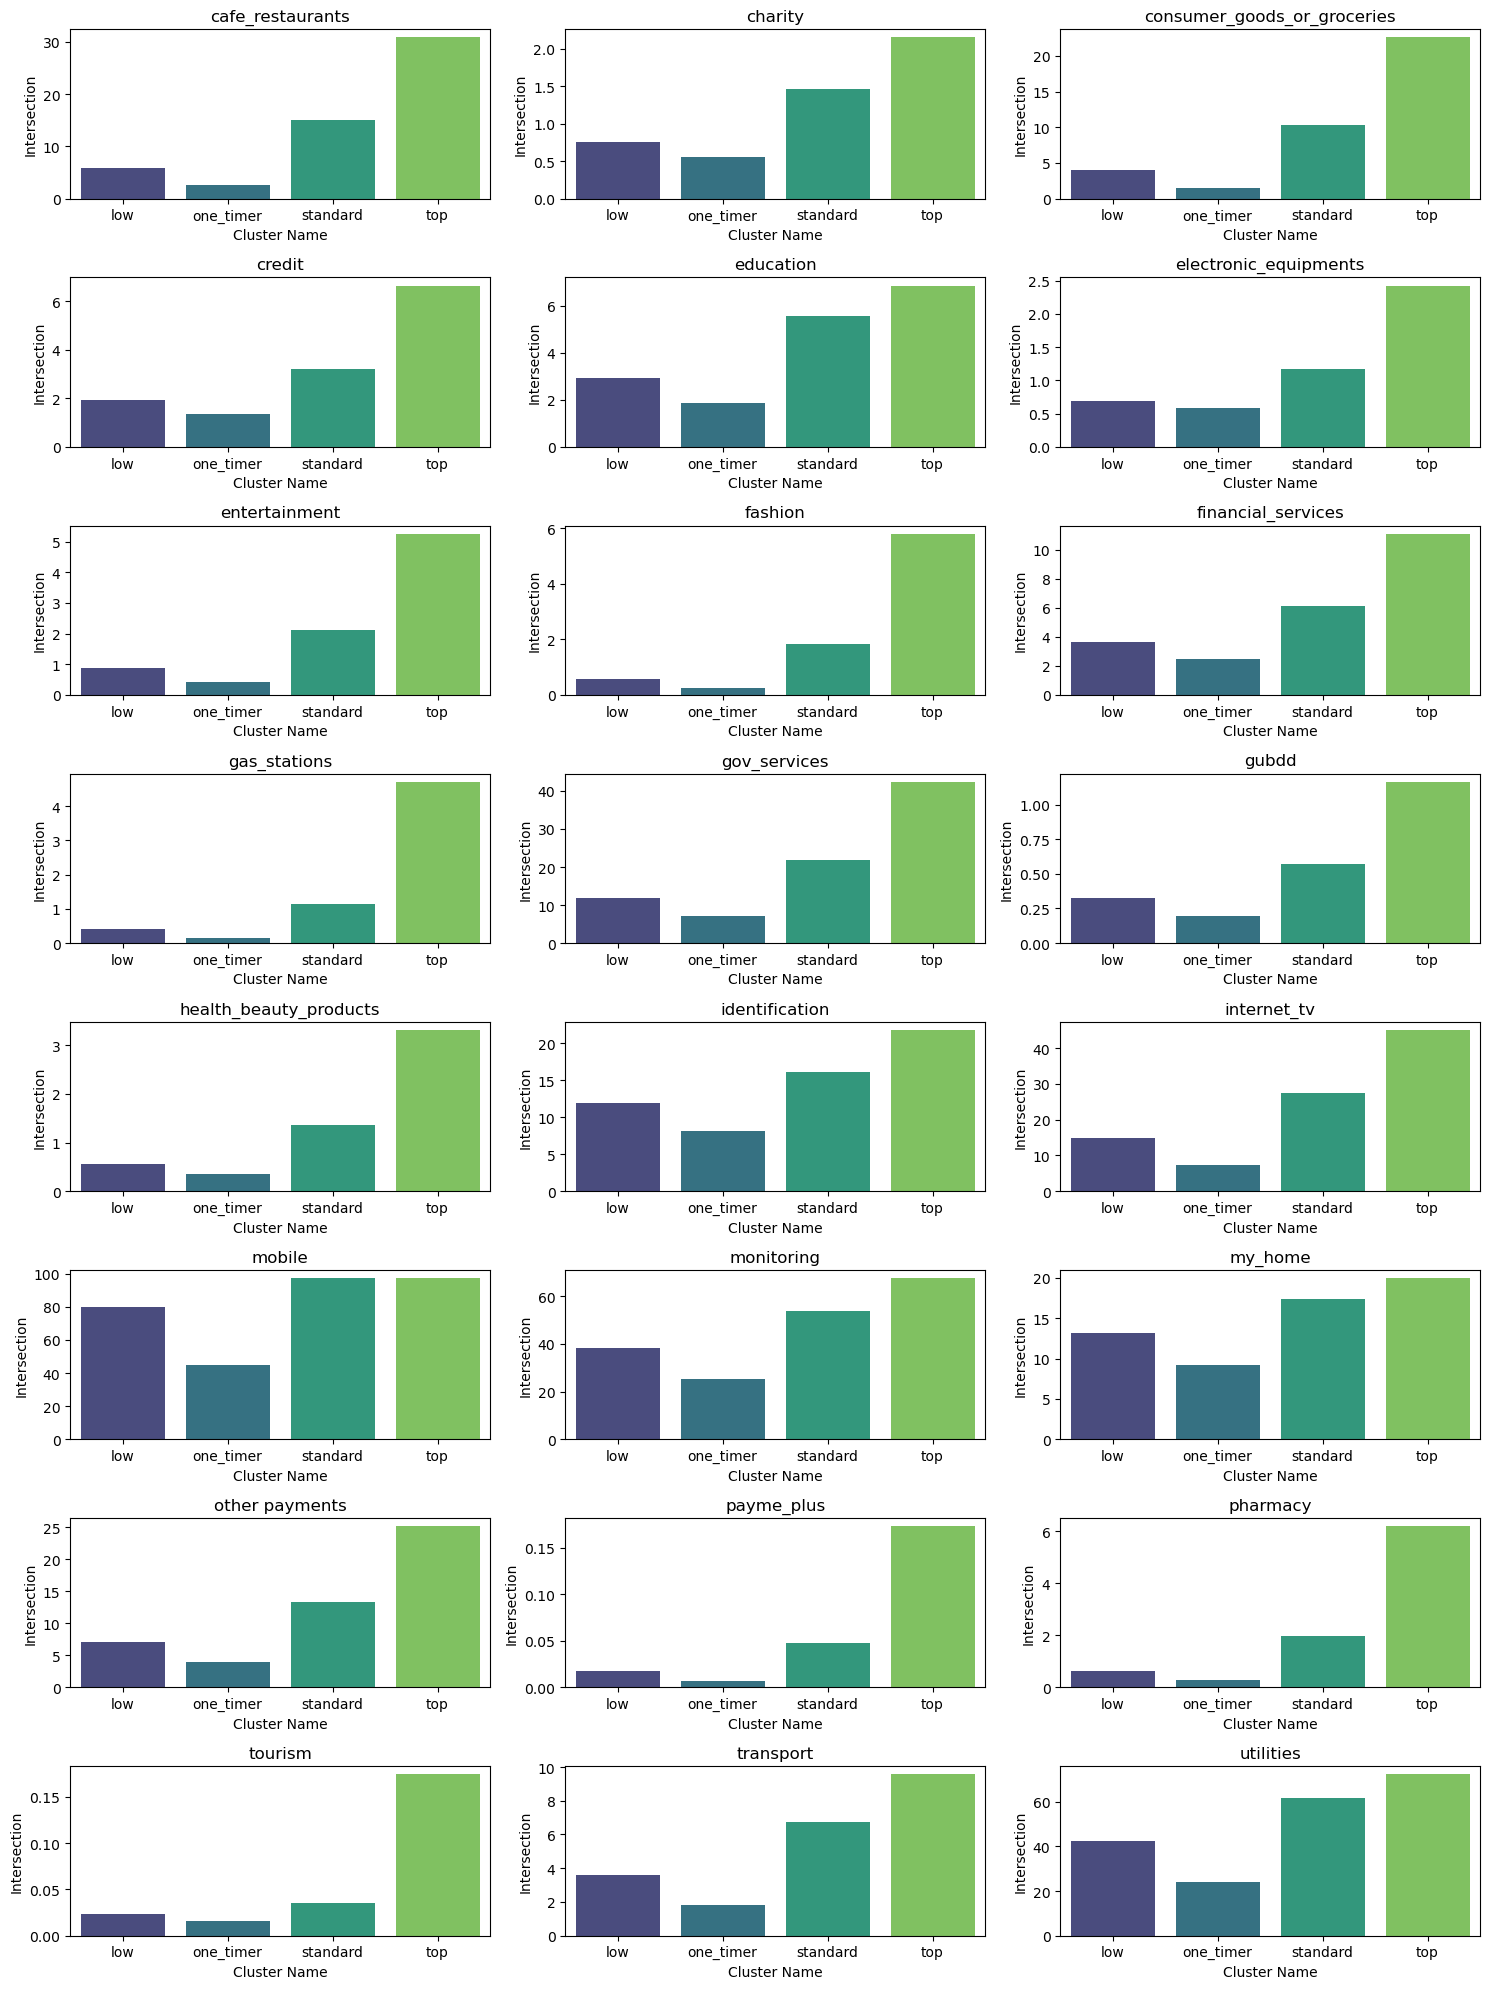

In [71]:
tr_types = tran_cl_grouped['tr_type'].unique()

# Create subplots
fig, axes = plt.subplots(8, 3, figsize=(15, 20), constrained_layout=True)
axes = axes.flatten()  # Flatten to easily iterate

# Plot each tr_type
for i, tr_type in enumerate(tr_types):
    ax = axes[i]
    data = tran_cl_grouped[tran_cl_grouped['tr_type'] == tr_type]
    sns.barplot(
        data=data,
        x='cluster_name',
        y='intersection_with_transfers',
        ax=ax,
        palette = 'viridis'
    )
    ax.set_title(tr_type)
    ax.set_xlabel('Cluster Name')
    ax.set_ylabel('Intersection')

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Final adjustments
plt.tight_layout()
plt.savefig(fname = 'plot1')
plt.show()


In [72]:
tran_cl_grouped['volume_per_user'] = tran_cl_grouped['amount']/tran_cl_grouped['payer_id']

C:\Users\MSI\AppData\Local\Temp\ipykernel_18648\3486228994.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


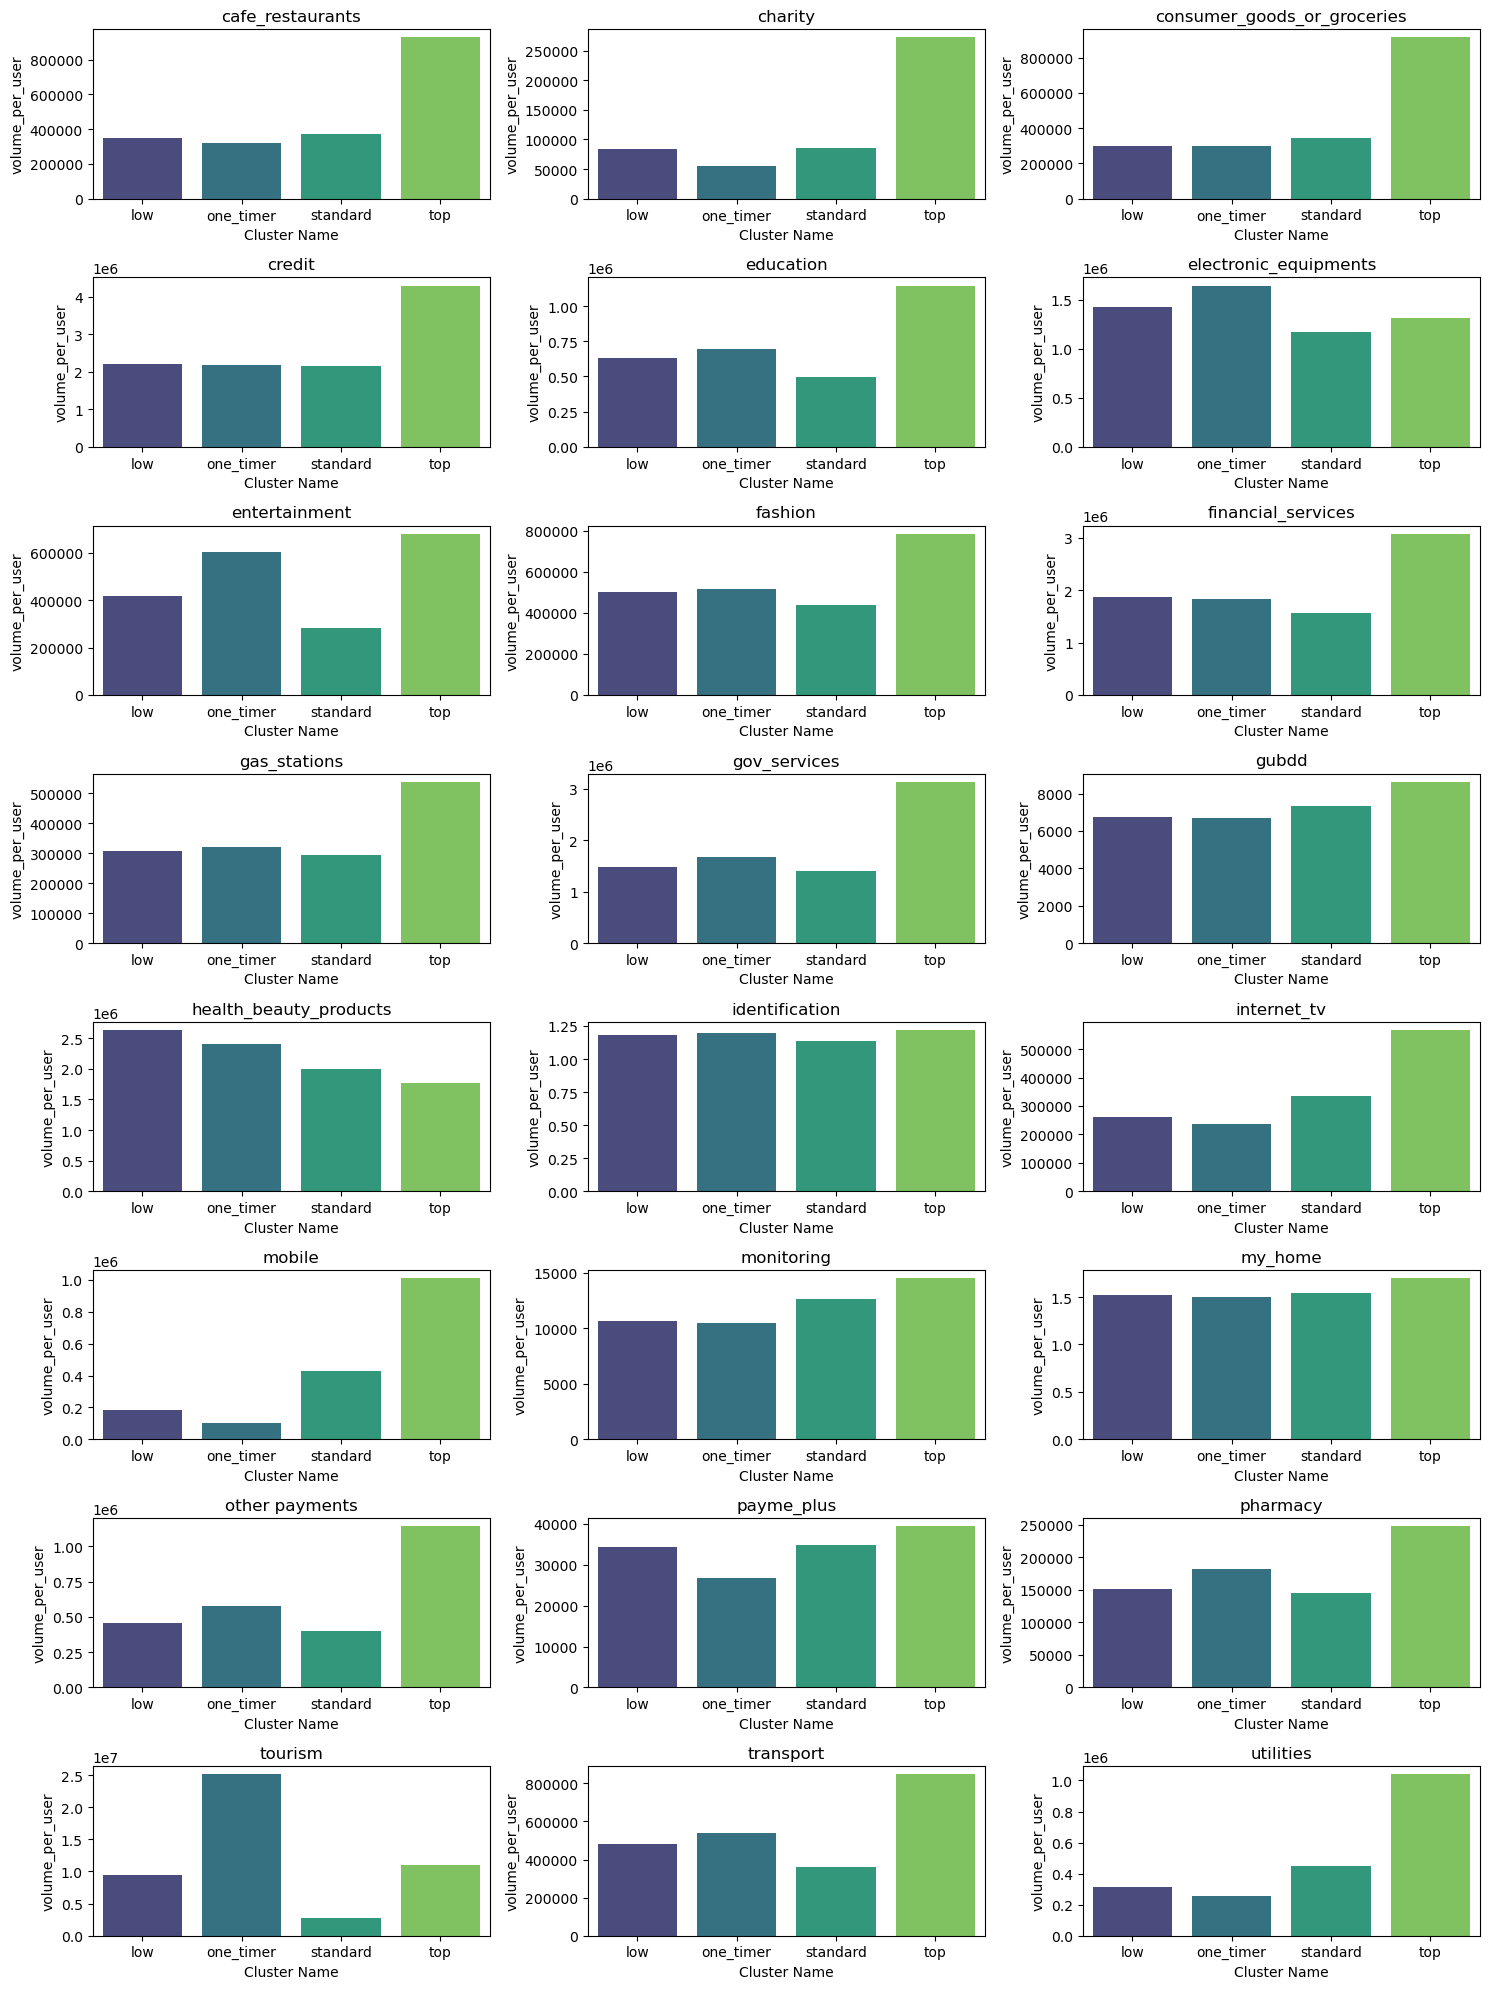

In [73]:
tr_types = tran_cl_grouped['tr_type'].unique()

# Create subplots
fig, axes = plt.subplots(8, 3, figsize=(15, 20), constrained_layout=True)
axes = axes.flatten()  # Flatten to easily iterate

# Plot each tr_type
for i, tr_type in enumerate(tr_types):
    ax = axes[i]
    data = tran_cl_grouped[tran_cl_grouped['tr_type'] == tr_type]
    sns.barplot(
        data=data,
        x='cluster_name',
        y='volume_per_user',
        ax=ax,
        palette = 'viridis'
    )
    ax.set_title(tr_type)
    ax.set_xlabel('Cluster Name')
    ax.set_ylabel('volume_per_user')

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Final adjustments
plt.tight_layout()
plt.savefig(fname = 'plot2')
plt.show()

## Transactions

In [60]:
p2p_tran = pd.read_sql("""
        select * from payme_sandbox.p2p_user_activation_transactions_with_p2p
""", con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_18504\1763041152.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  p2p_tran = pd.read_sql("""


In [61]:
p2p_tran_cl = pd.merge(p2p_tran, clusters[['payer_id', 'cluster_name']], how = 'inner', on = 'payer_id')
p2p_tran_cld = pd.get_dummies(p2p_tran_cl, columns=['cluster_name'], dtype = 'int')
p2p_tran_cld['cluster_name'] = p2p_tran_cl['cluster_name']
p2p_tran_cl.sort_values(['payer_id', 'rn'], inplace = True)

In [62]:
p2p_tran_cld

payer_id                      create_time  \
0         63b09065a8ee7ccefc9d922d 2023-02-14 14:32:45.931000+00:00   
1         63b09065a8ee7ccefc9d922d 2023-03-27 05:08:29.314000+00:00   
2         63b09065a8ee7ccefc9d922d 2023-03-27 05:13:01.848000+00:00   
3         63b09065a8ee7ccefc9d922d 2023-04-04 02:10:13.882000+00:00   
4         63b09065a8ee7ccefc9d922d 2023-05-24 06:43:52.325000+00:00   
...                            ...                              ...   
79763013  66099cfb46e985a462e6326f 2024-06-18 13:40:42.268000+00:00   
79763014  66099cfb46e985a462e6326f 2024-05-23 05:22:07.612000+00:00   
79763015  66099cfb46e985a462e6326f 2024-09-05 09:17:52.456000+00:00   
79763016  66099cfb46e985a462e6326f 2024-09-05 09:09:02.181000+00:00   
79763017  660917a1f6534cf962057f96 2024-08-22 08:18:21.187000+00:00   

                 tr_type     amount  days_after_registration  rn  \
0                    p2p   600000.0                     44.0   6   
1                    p2p    10000.0                     85.0  16   
2                    p2p    90000.0                     85.0  17   
3                    p2p    40000.0                     93.0  22   
4                    p2p  1600000.0                    143.0  56   
...                  ...        ...                      ...  ..   
79763013             p2p    20000.0                     78.0   2   
79763014  identification        1.0                     52.0   1   
79763015             p2p    15000.0                    157.0   4   
79763016             p2p    15000.0                    157.0   3   
79763017             p2p    90000.0                    144.0   1   

          cluster_name_low  cluster_name_one_timer  cluster_name_standard  \
0                        0                       0                      0   
1                        0                       0                      0   
2                        0                       0                      0   
3                        0                       0                      0   
4                        0                       0                      0   
...                    ...                     ...                    ...   
79763013                 1                       0                      0   
79763014                 1                       0                      0   
79763015                 1                       0                      0   
79763016                 1                       0                      0   
79763017                 0                       1                      0   

          cluster_name_top cluster_name  
0                        1          top  
1                        1          top  
2                        1          top  
3                        1          top  
4                        1          top  
...                    ...          ...  
79763013                 0          low  
79763014                 0          low  
79763015                 0          low  
79763016                 0          low  
79763017                 0    one_timer  

[79763018 rows x 11 columns]

In [63]:
p2p_tran_cld_filtered = p2p_tran_cld[p2p_tran_cld.days_after_registration < 91]
p2p_tran_cld_filtered = p2p_tran_cld_filtered[p2p_tran_cld_filtered.tr_type == 'mobile']


In [64]:
p2p_tran_cld_filtered = p2p_tran_cld_filtered.groupby('payer_id').agg({'amount':'count', 'cluster_name_standard':'mean'})

In [68]:
p2p_tran_p2p_only = p2p_tran_cld[p2p_tran_cld.tr_type == 'p2p']

### p2p 30 days

In [69]:
p2p_tran_p2p_only_30 = p2p_tran_p2p_only[p2p_tran_p2p_only.days_after_registration < 31]
p2p_tran_p2p_only_30 = p2p_tran_p2p_only_30.groupby('payer_id').agg({'rn':'count', 'cluster_name_standard':'max'}).reset_index()
p2p_tran_p2p_only_30 = p2p_tran_p2p_only_30.groupby('rn')['cluster_name_standard'].mean().reset_index()

C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


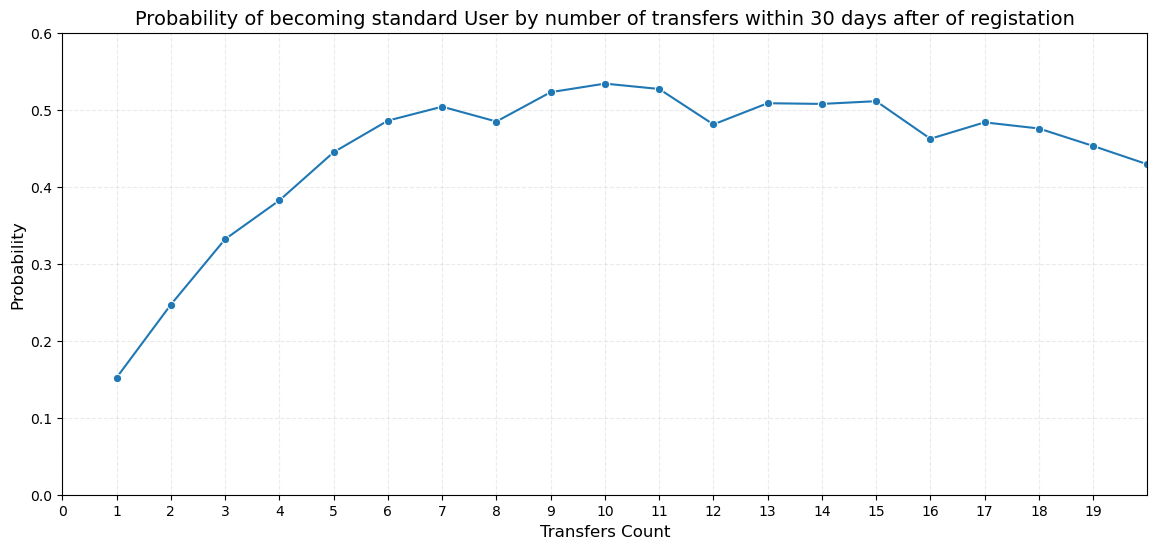

In [70]:
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=p2p_tran_p2p_only_30, 
    x='rn', 
    y='cluster_name_standard', 
    marker='o'
)
plt.title('Probability of becoming standard User by number of transfers within 30 days after of registation', fontsize=14)
plt.xlabel('Transfers Count', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.25)
plt.xlim(0, 20)
plt.ylim(0, 0.6)
plt.xticks(np.arange(0, 20, 1))
plt.show()


C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


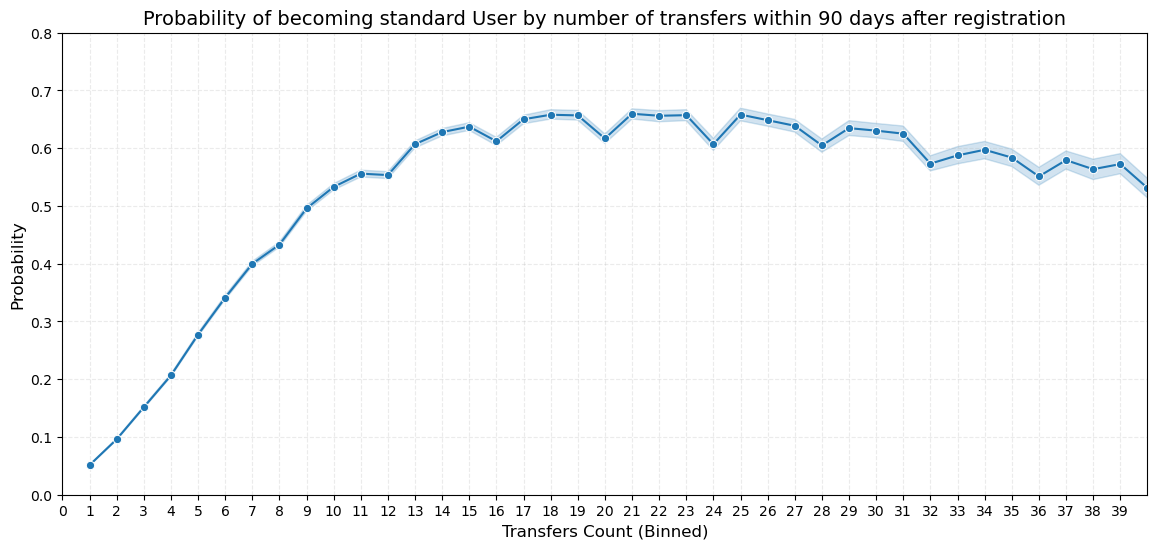

In [71]:
p2p_tran_p2p_only_90 = p2p_tran_p2p_only[p2p_tran_p2p_only.days_after_registration < 91]
p2p_tran_p2p_only_90 = p2p_tran_p2p_only_90.groupby('payer_id').agg({'rn': 'count', 'cluster_name_standard': 'max'}).reset_index()

# Apply bins of size 5 to 'rn'
#p2p_tran_p2p_only_90['rn_bins'] = (p2p_tran_p2p_only_90['rn'] // 2) * 2  # Rounds to nearest multiple of 2

# Group by bins and calculate the mean probability
#p2p_tran_p2p_only_90 = p2p_tran_p2p_only_90.groupby('rn_bins')['cluster_name_standard'].mean().reset_index()

# Plot the binned data
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=p2p_tran_p2p_only_90, 
    x='rn', 
    y='cluster_name_standard', 
    marker='o'
)
plt.title('Probability of becoming standard User by number of transfers within 90 days after registration', fontsize=14)
plt.xlabel('Transfers Count (Binned)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.25)
plt.xlim(0, 40)
plt.ylim(0, 0.8)
plt.xticks(np.arange(0, 40, 1))  # Ensure consistent ticks
plt.show()

C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

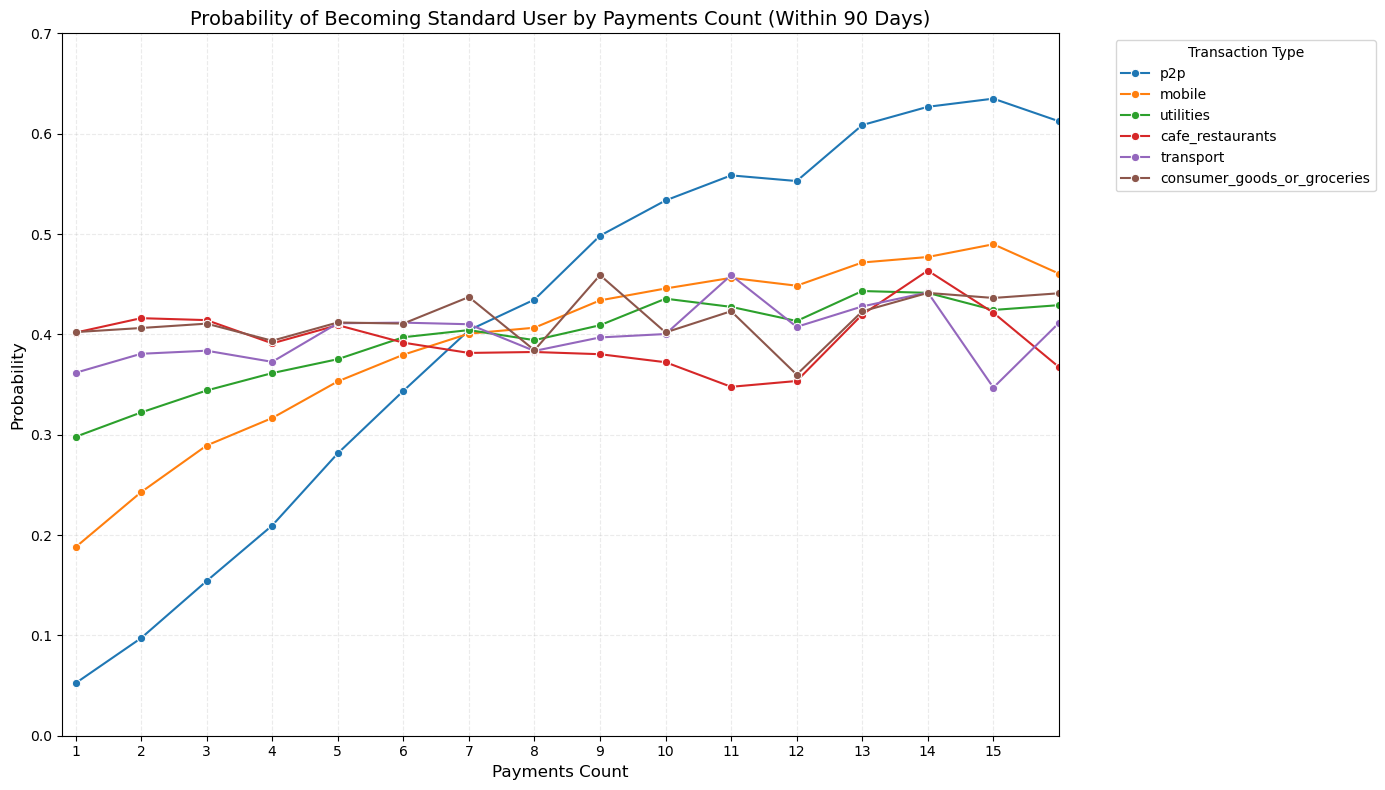

In [76]:
plt.figure(figsize=(14, 8))

# Loop through each `tr_type` value
for tr_type in ['p2p', 'mobile', 'utilities', 'cafe_restaurants', 'transport', 'consumer_goods_or_groceries']:
    # Filter the data for the current tr_type
    filtered_data = p2p_tran_cld[p2p_tran_cld.tr_type == tr_type]
    filtered_data = filtered_data[filtered_data.days_after_registration < 90]
    

    # Group by payer_id and then aggregate
    grouped_data = (
        filtered_data.groupby('payer_id').agg({'rn': 'count', 'cluster_name_standard': 'max'}).reset_index()
    )
    # Group by rn to calculate the mean
    aggregated_data = (
        grouped_data.groupby('rn')['cluster_name_standard']
        .mean()
        .reset_index()
    )
    
    # Plot the data
    sns.lineplot(
        data=aggregated_data,
        x='rn',
        y='cluster_name_standard',
        label=tr_type,
        marker='o'
    )

# Customize the plot
plt.title('Probability of Becoming Standard User by Payments Count (Within 90 Days)', fontsize=14)
plt.xlabel('Payments Count', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.legend(title='Transaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.25)
plt.xlim(0.8, 16)
plt.ylim(0, 0.7)
plt.xticks(np.arange(1, 16, 1))
plt.tight_layout()
plt.show()

C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

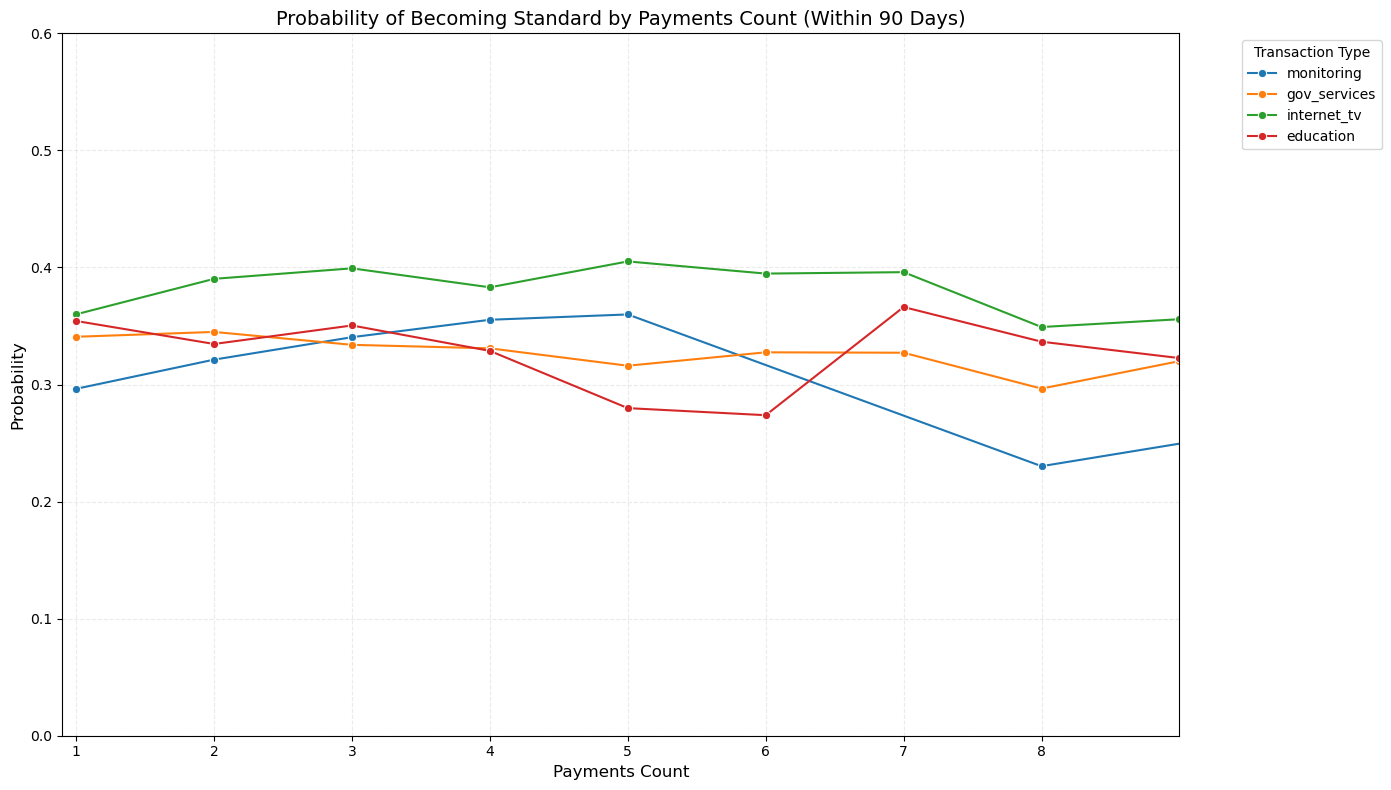

In [80]:
plt.figure(figsize=(14, 8))

# Loop through each `tr_type` value
for tr_type in ['monitoring', 'gov_services', 'internet_tv', 'education']:
    # Filter the data for the current tr_type
    filtered_data = p2p_tran_cld[p2p_tran_cld.tr_type == tr_type]
    filtered_data = filtered_data[filtered_data.days_after_registration < 90]
    
    # Group by payer_id and then aggregate
    grouped_data = (
        filtered_data.groupby('payer_id')
        .agg({'rn': 'count', 'cluster_name_standard': 'max'})
        .reset_index()
    )
    # Group by rn to calculate the mean
    aggregated_data = (
        grouped_data.groupby('rn')['cluster_name_standard']
        .mean()
        .reset_index()
    )
    
    # Plot the data
    sns.lineplot(
        data=aggregated_data,
        x='rn',
        y='cluster_name_standard',
        label=tr_type,
        marker='o'
    )

# Customize the plot
plt.title('Probability of Becoming Standard by Payments Count (Within 90 Days)', fontsize=14)
plt.xlabel('Payments Count', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.legend(title='Transaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.25)
plt.xlim(0.9, 9)
plt.ylim(0, 0.6)
plt.xticks(np.arange(1, 9, 1))
plt.tight_layout()
plt.show()

C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

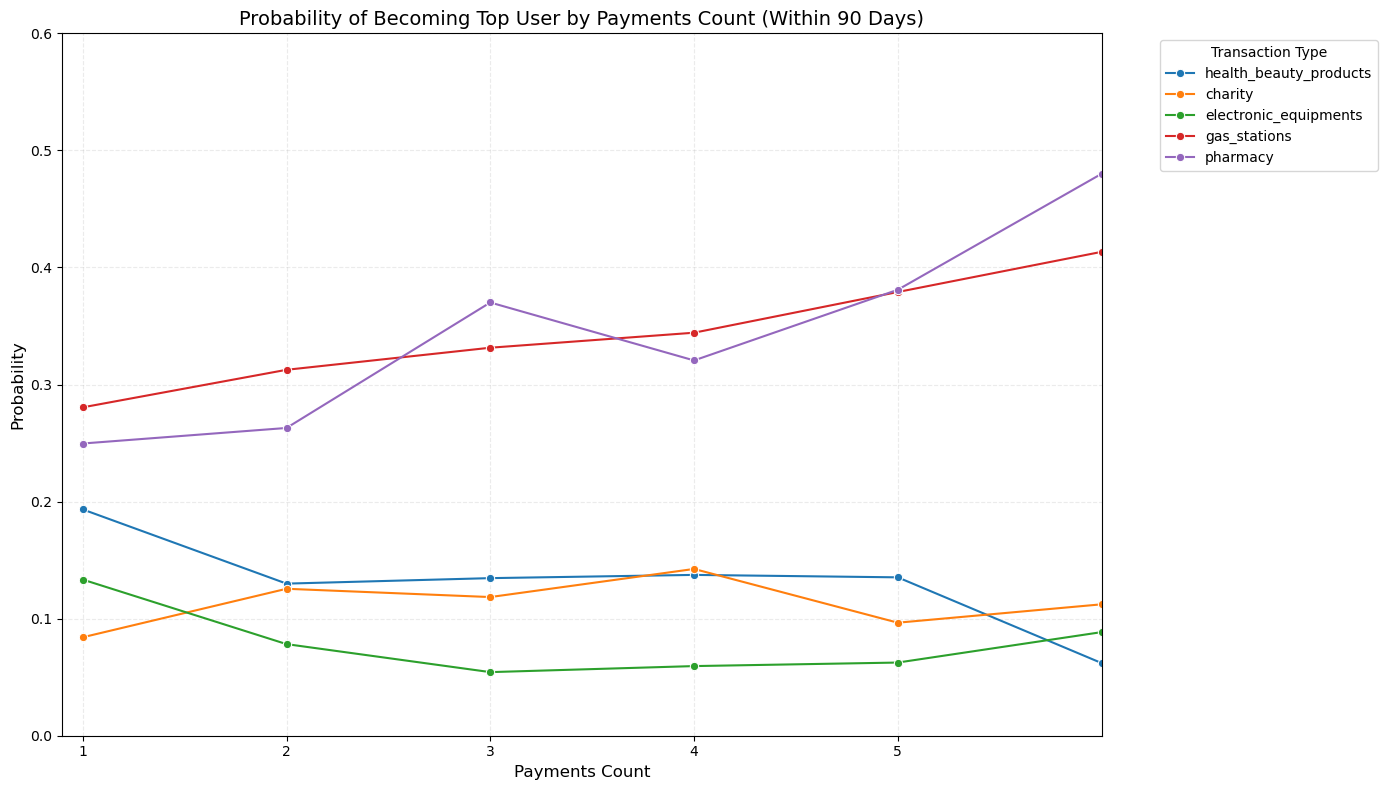

In [78]:
plt.figure(figsize=(14, 8))

# Loop through each `tr_type` value
for tr_type in ['health_beauty_products', 'charity', 'electronic_equipments', 'gas_stations', 'pharmacy']:
    # Filter the data for the current tr_type
    filtered_data = p2p_tran_cld[p2p_tran_cld.tr_type == tr_type]
    filtered_data = filtered_data[filtered_data.days_after_registration < 90]
    
    # Group by payer_id and then aggregate
    grouped_data = (
        filtered_data.groupby('payer_id')
        .agg({'rn': 'count', 'cluster_name_top': 'max'})
        .reset_index()
    )
    # Group by rn to calculate the mean
    aggregated_data = (
        grouped_data.groupby('rn')['cluster_name_top']
        .mean()
        .reset_index()
    )
    
    # Plot the data
    sns.lineplot(
        data=aggregated_data,
        x='rn',
        y='cluster_name_top',
        label=tr_type,
        marker='o'
    )

# Customize the plot
plt.title('Probability of Becoming Top User by Payments Count (Within 90 Days)', fontsize=14)
plt.xlabel('Payments Count', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.legend(title='Transaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.25)
plt.xlim(0.9, 6)
plt.ylim(0, 0.6)
plt.xticks(np.arange(1, 6, 1))
plt.tight_layout()
plt.show()

In [91]:
p2p_tran_cl2 = p2p_tran_cl[p2p_tran_cl['rn'] == 1]
p2p_tran_cl2_gr = p2p_tran_cl2.groupby('payer_id')['tr_type'].apply(lambda x: ' -> '.join(x)).reset_index()
p2p_tran_cl2_gr = p2p_tran_cl2_gr.merge(clusters[['payer_id', 'cluster_name']], how = 'inner', on = 'payer_id')

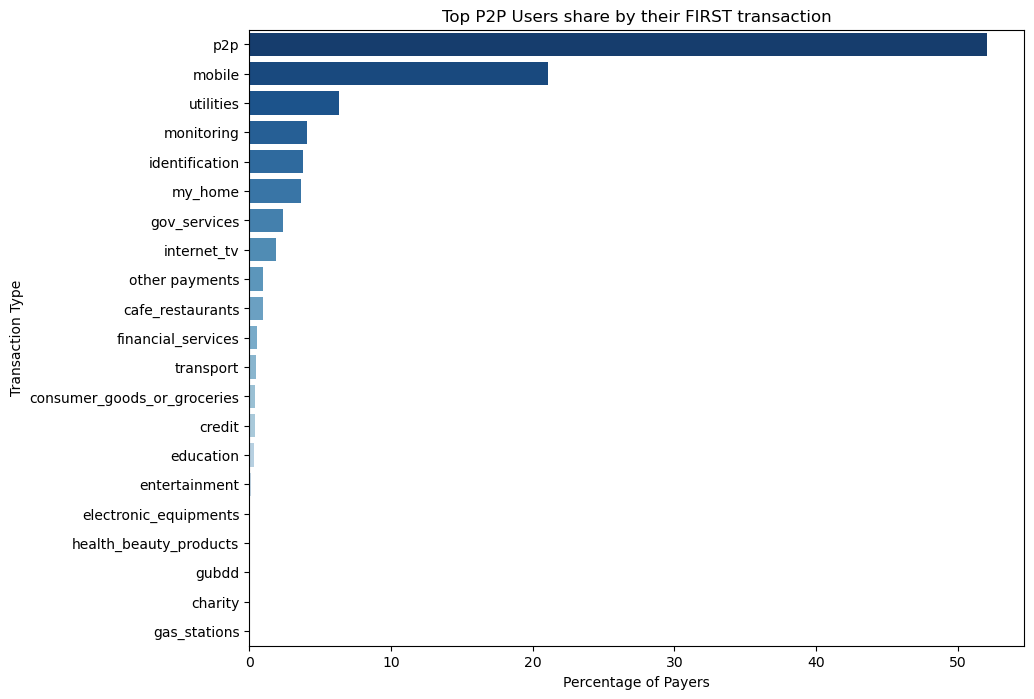

In [92]:
top_data = p2p_tran_cl2_gr[p2p_tran_cl2_gr['cluster_name'] == 'standard'].groupby('tr_type')['payer_id'].count().reset_index()
total_payers = top_data['payer_id'].sum()
top_data['percentage'] = (top_data['payer_id'] / total_payers) * 100

top_data = top_data.sort_values('percentage', ascending=False).head(21)

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x='percentage', y='tr_type', data=top_data, palette='Blues_r')

# Adding labels and title
plt.xlabel("Percentage of Payers")
plt.ylabel("Transaction Type")
plt.title("Top P2P Users share by their FIRST transaction")

# Show the plot
plt.show()

In [93]:
p2p_tran_cl2 = p2p_tran_cl[p2p_tran_cl['rn'] < 3]
p2p_tran_cl2_gr = p2p_tran_cl2.groupby('payer_id')['tr_type'].apply(lambda x: ' -> '.join(x)).reset_index()
p2p_tran_cl2_gr = p2p_tran_cl2_gr.merge(clusters[['payer_id', 'cluster_name']], how = 'inner', on = 'payer_id')

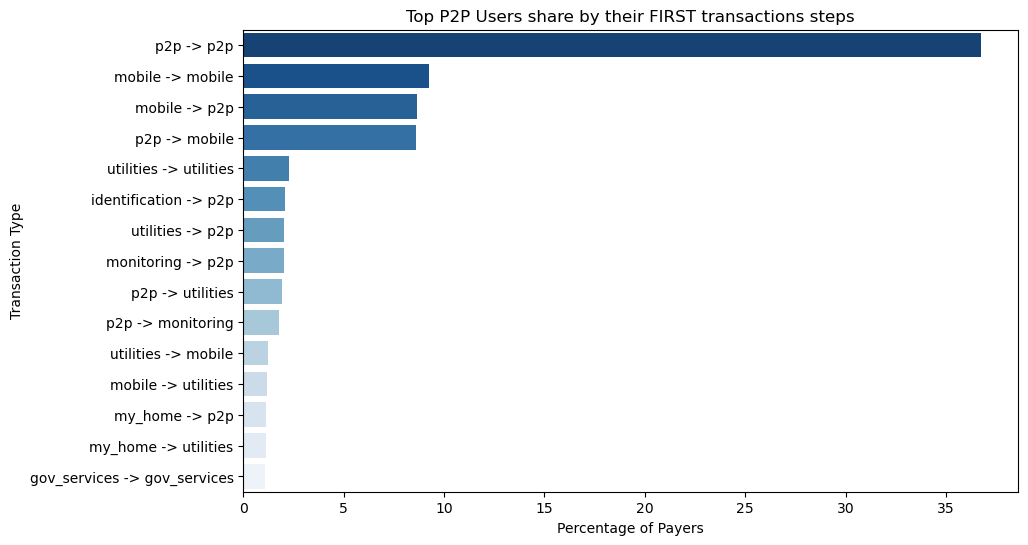

In [94]:
top_data = p2p_tran_cl2_gr[p2p_tran_cl2_gr['cluster_name'] == 'top'].groupby('tr_type')['payer_id'].count().reset_index()
total_payers = top_data['payer_id'].sum()
top_data['percentage'] = (top_data['payer_id'] / total_payers) * 100

top_data = top_data.sort_values('percentage', ascending=False).head(15)

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='percentage', y='tr_type', data=top_data, palette='Blues_r')

# Adding labels and title
plt.xlabel("Percentage of Payers")
plt.ylabel("Transaction Type")
plt.title("Top P2P Users share by their FIRST transactions steps")

# Show the plot
plt.show()

In [95]:
p2p_tran_cl2 = p2p_tran_cl[p2p_tran_cl['rn'] < 4]
p2p_tran_cl2_gr = p2p_tran_cl2.groupby('payer_id')['tr_type'].apply(lambda x: ' -> '.join(x)).reset_index()
p2p_tran_cl2_gr = p2p_tran_cl2_gr.merge(clusters[['payer_id', 'cluster_name']], how = 'inner', on = 'payer_id')

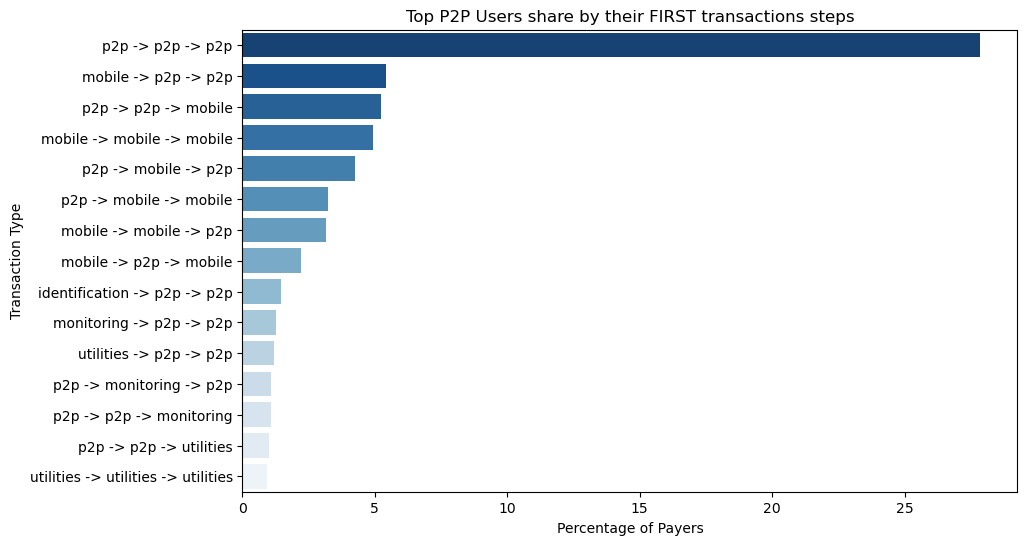

In [96]:
top_data = p2p_tran_cl2_gr[p2p_tran_cl2_gr['cluster_name'] == 'top'].groupby('tr_type')['payer_id'].count().reset_index()
total_payers = top_data['payer_id'].sum()
top_data['percentage'] = (top_data['payer_id'] / total_payers) * 100

top_data = top_data.sort_values('percentage', ascending=False).head(15)

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='percentage', y='tr_type', data=top_data, palette='Blues_r')

# Adding labels and title
plt.xlabel("Percentage of Payers")
plt.ylabel("Transaction Type")
plt.title("Top P2P Users share by their FIRST transactions steps")

# Show the plot
plt.show()

In [97]:
p2p_tran_cl2 = p2p_tran_cl[p2p_tran_cl['rn'] < 6]
p2p_tran_cl2_gr = p2p_tran_cl2.groupby('payer_id')['tr_type'].apply(lambda x: ' -> '.join(x)).reset_index()
p2p_tran_cl2_gr = p2p_tran_cl2_gr.merge(clusters[['payer_id', 'cluster_name']], how = 'inner', on = 'payer_id')

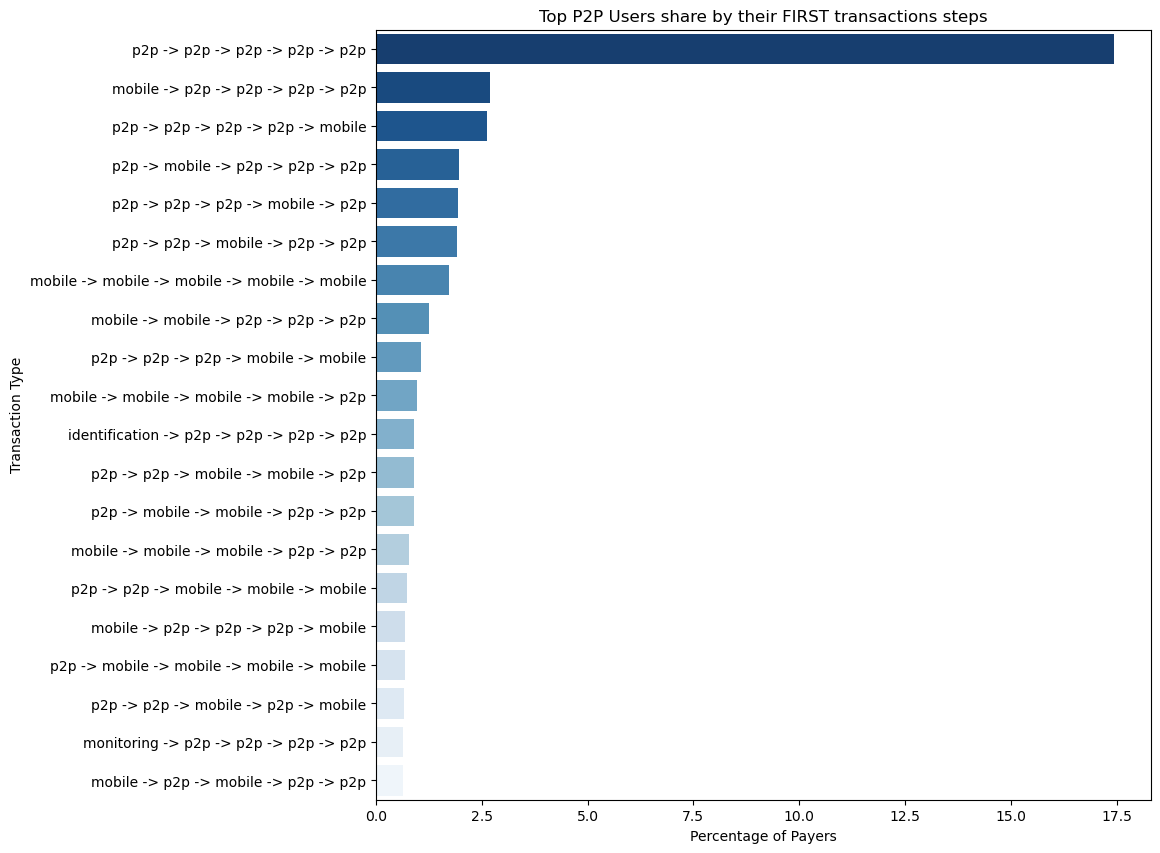

In [98]:
top_data = p2p_tran_cl2_gr[p2p_tran_cl2_gr['cluster_name'] == 'top'].groupby('tr_type')['payer_id'].count().reset_index()
total_payers = top_data['payer_id'].sum()
top_data['percentage'] = (top_data['payer_id'] / total_payers) * 100

top_data = top_data.sort_values('percentage', ascending=False).head(20)

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 10))
sns.barplot(x='percentage', y='tr_type', data=top_data, palette='Blues_r')

# Adding labels and title
plt.xlabel("Percentage of Payers")
plt.ylabel("Transaction Type")
plt.title("Top P2P Users share by their FIRST transactions steps")

# Show the plot
plt.show()

In [ ]:
np.arange()

In [7]:
clusters.columns

Index(['payer_id', 'mean_days', 'median_days', 'std_days', 'min_days',
       'max_days', 'count_days', 'skew_days', 'kurtosis_days', 'q25_days',
       'q75_days', 'q90_days', 'mean_amount', 'median_amount', 'count_trn',
       'sum_amount', 'std_amount', 'median_gap', 'iqr', 'variation', 'cluster',
       'cluster_0_probability', 'cluster_1_probability',
       'cluster_2_probability', 'cluster_3_probability',
       'max_probability_cluster', 'cluster_name'],
      dtype='object')

In [ ]:
['count_days', 'q90_days', 'mean_amount',  'sum_amount', 'std_amount', 'median_gap', 'iqr', 'variation', 'cluster',
       'cluster_0_probability', 'cluster_1_probability',
       'cluster_2_probability', 'cluster_3_probability',
       'max_probability_cluster', 'cluster_name']

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [46]:
features = ['q90_days', 'sum_amount', 'iqr']
X = clusters[features]  # Explanatory variables
y = clusters['cluster_name']  # Target variable

In [47]:
# Standardize the features (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [48]:
# ===== Step 2: Apply PCA =====
pca = PCA(n_components=2)  # Reduce to 2D
X_pca = pca.fit_transform(X_scaled)  # Transform data

In [49]:
# Create a new DataFrame for visualization
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster_name'] = y  # Add the target variable back

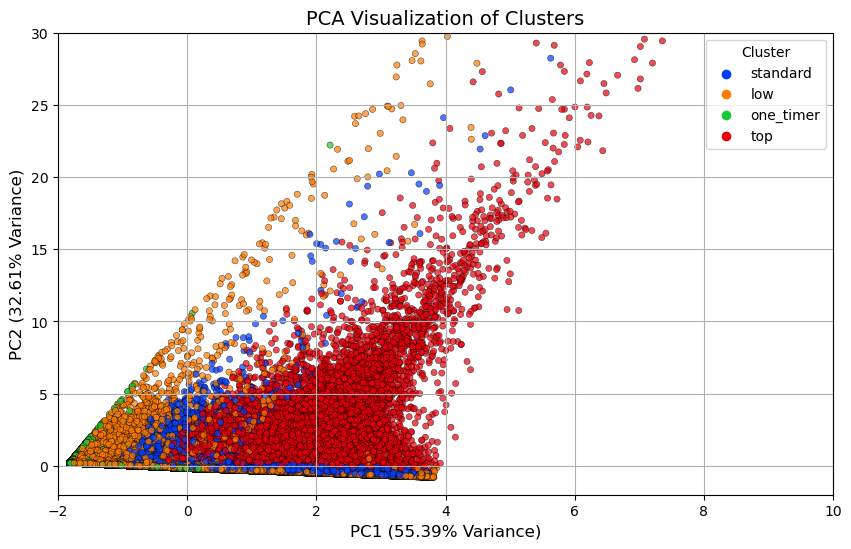

In [56]:
# ===== Step 3: Plot the Results =====
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_name', palette='bright', alpha=0.7, edgecolor='black', s=20)

# Customize the plot
plt.title('PCA Visualization of Clusters', fontsize=14)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)', fontsize=12)
plt.xlim(-2, 10)
plt.ylim(-2, 30)
plt.legend(title="Cluster", fontsize=10)
plt.grid(True)
plt.show()

In [51]:
print(f'Explained Variance Ratio: {pca.explained_variance_ratio_}')

Explained Variance Ratio: [0.55389182 0.32610978]


In [52]:
print(pd.DataFrame(pca.components_, columns=features, index=['PC1', 'PC2']))


     q90_days  sum_amount       iqr
PC1  0.694469    0.179067  0.696884
PC2 -0.140584    0.983639 -0.112653


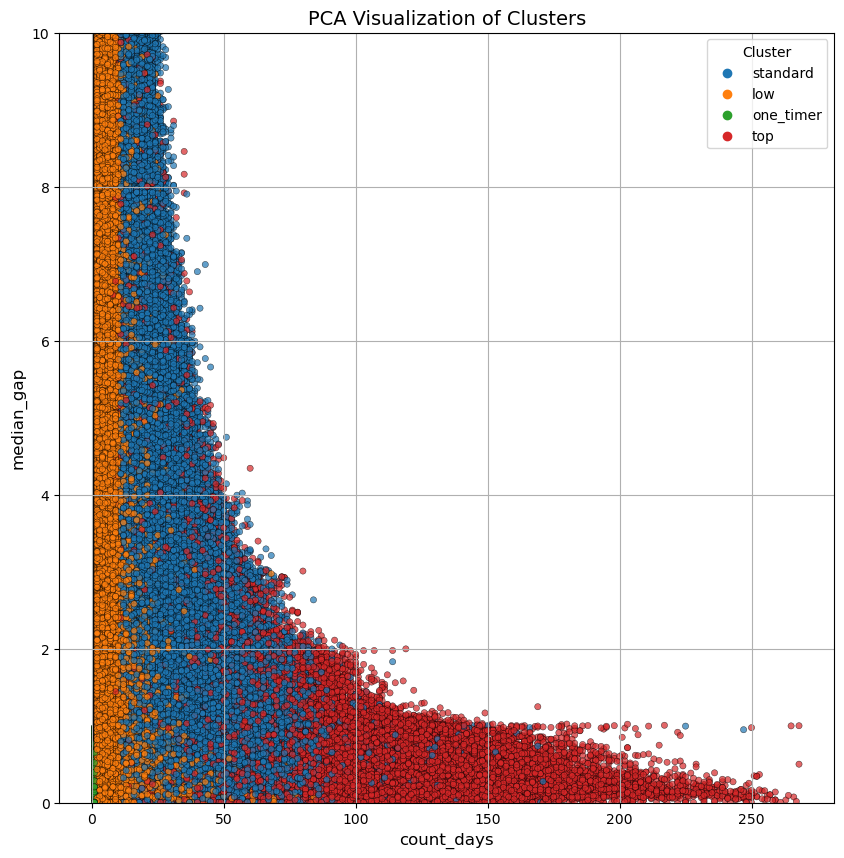

In [110]:
# ===== Step 3: Plot the Results =====
plt.figure(figsize=(10, 10))
sns.scatterplot(data=clusters, x='count_days', y='median_gap', hue='cluster_name', alpha=0.7, edgecolor='black', s=20)

# Customize the plot
plt.title('PCA Visualization of Clusters', fontsize=14)
plt.xlabel('count_days', fontsize=12)
plt.ylabel('median_gap', fontsize=12)
#plt.xlim(-3, 3)
plt.ylim(0, 10)
plt.legend(title="Cluster", fontsize=10)
plt.grid(True)
plt.show()

In [108]:
clusters.median_gap.describe()

count    1.694433e+06
mean     9.807130e+00
std      2.386036e+01
min      0.000000e+00
25%      3.318021e-01
50%      1.961870e+00
75%      7.609152e+00
max      2.699732e+02
Name: median_gap, dtype: float64